#Setup

##Packages and Libraries

In [ ]:
!pip install geopandas &> /dev/null

In [ ]:
from osgeo import gdal, gdal_array
import ogr
import osr
import os
import geopandas as gpd
import numpy as np
import pandas as pd
from jdcal import gcal2jd, jd2gcal
import sys
import time
from joblib import Parallel, delayed
import multiprocessing
from google.colab import drive
from matplotlib import pyplot as plt
import math
import scipy
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from tqdm import tqdm
from datetime import datetime
from skimage.io import imread
import re

In [ ]:
sys.path.append('/usr/bin/')

In [ ]:
import gdal_merge as gm

##Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#Image Procedures

##Fill No Data

In [ ]:
#Get list of images
directories = ['/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/Raw/']
list_images = []

for directory in directories:
  for subdir, dirs, files in os.walk(directory):
      for filename in files:
          filepath = subdir + os.sep + filename
          #if filepath.endswith(".tif") or filepath.endswith(".TIF"):
          if re.search("[0-9]{1,2}\.TIF$",filepath) and 'B2.TIF' in filepath:
            list_images.append(filepath)

In [ ]:
rasterfile = '/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/Raw/LC08_L2SP_233078_20150213_20200909_02_T1/LC08_L2SP_233078_20150213_20200909_02_T1_SR_B2.TIF'
rlayer = gdal.Open(rasterfile, gdal.GA_ReadOnly)
band = rlayer.GetRasterBand(1)
band

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7f4670515a80> >

In [ ]:
test = gdal.FillNodata(band,None,100,1)

## Image Merging

In [ ]:
bands = ['B1','B2','B3','B4','B5','B6','B7','B10','ASTER','NDSI']
#bands = ['NDSI','ASTER']
buffers = ['Buffer_0']
glaciers = list(range(1,357))
glaciers = ["Number_" + str(s) for s in glaciers]
glaciers

In [ ]:
#Get list of images to mosaic
#directories = ['/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/','/content/drive/MyDrive/Thesis_Data/DEM/ASTER/ASTER_32619_ALIGNED/ASTER']
input_directory = '/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/AtacamaRegion/'
output_directory = '/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/AtacamaRegion/All_channels/'
#output_directory = '/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/AtacamaRegion/'

with tqdm(total=len(buffers)*len(glaciers)) as pbar:
  for buffer in buffers:
    for glacier in glaciers:

      output_image = output_directory + glacier + '.TIF'
      #output_image = output_directory + 'test.TIF'
      list_images = []
      
      #create list of file images
      for band in bands:
        for subdir, dirs, files in os.walk(input_directory+band):
            for filename in files:
                filepath = subdir + os.sep + filename
                if filepath.endswith(".tif") or filepath.endswith(".TIF"):
                  if (glacier+'.tif' in filepath or glacier+'.TIF' in filepath) and buffer in filepath:
                    list_images.append(filepath)

      
      #print(list_images)
      
      parameters = ['', '-o', output_image,'-separate'] #remove separate if no need to put files in different bands
      parameters.extend(list_images)
      try:
        #print(parameters)
        gm.main(parameters)
        #print("ok")
      except:
        print("Error in " + buffer + " " + glacier)
      pbar.update(1)

100%|██████████| 356/356 [18:33<00:00,  3.13s/it]


##Move Files

In [ ]:
from shutil import copyfile

In [ ]:
directory = '/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/B3'
dst_folder = '/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/All_bands/'

for subdir, dirs, files in os.walk(directory):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith(".tif") or filepath.endswith(".TIF"):
          if 'Mask3' in filepath:
            #print(filepath)
            dst = filepath.replace('/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/B3/B3_',dst_folder)
            dst = dst.replace('Buffer_0','Buffer_0/Buffer_0')
            dst = dst.replace('Buffer_P15','Buffer_P15/Buffer_P15')
            dst = dst.replace('Mask3','Mask')
            #print(dst)
            try:
              copyfile(filepath, dst)
            except:
              print("Error in: " + filepath)

In [ ]:
dest = '/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/All_bands/Buffer_0/Buffer_0_Number_100_Mask.tif'


##Virtual Layer

Links of interest


*   [https://gdal.org/python/osgeo.gdal-module.html](https://gdal.org/python/osgeo.gdal-module.html)
*   [https://gis.stackexchange.com/questions/44003/python-equivalent-of-gdalbuildvrt](https://gis.stackexchange.com/questions/44003/python-equivalent-of-gdalbuildvrt)
*   [Testing](https://gsp.humboldt.edu/OLM/Courses/GSP_216_Online/lesson3-1/composites.html)
*   [gdalbuildvrt](https://gis.stackexchange.com/questions/44003/python-equivalent-of-gdalbuildvrt)
*   [gdalbuildvrt](https://gdal.org/programs/gdalbuildvrt.html)







In [ ]:
image1 = "/content/drive/MyDrive/UVA - Information Studies/Thesis/Data/Thesis_Data/Satellite Scenes/13FEB15/B7.TIF"
image2 = "/content/drive/MyDrive/UVA - Information Studies/Thesis/Data/Thesis_Data/Satellite Scenes/13FEB15/B4.TIF"
image3 = "/content/drive/MyDrive/UVA - Information Studies/Thesis/Data/Thesis_Data/Satellite Scenes/13FEB15/B2.TIF"
output_image = "/content/drive/MyDrive/UVA - Information Studies/Thesis/Data/Thesis_Data/Satellite Scenes/13FEB15/false_composite_742.tif"

In [ ]:
vrt_options = gdal.BuildVRTOptions(separate=True)
my_vrt = gdal.BuildVRT(output_image, [image1, image2, image3], options=vrt_options)
my_vrt = None

##Reproject

In [ ]:
def projectionshp(Rasterfile,inputfile,outputfile):

  # AIM : reproject a shp file accorduing to the projection of a raster
  # INPUT PARAMETERS :	Rasterfile -> input rasterfile
  #			inputfile -> intput shapefile
  #			outputfile -> output shapefile reprojected
  # OUTPUT : return the projection of the input raster	
	
	## Open HDF file
  rlayer = gdal.Open(Rasterfile, gdal.GA_ReadOnly)
  
	# Open raster layer
	#rlayer = gdal.Open(hdflayer.GetSubDatasets()[Band_number][0], gdal.GA_ReadOnly)
  outSpatialRef = osr.SpatialReference(wkt=rlayer.GetProjection())

  hdflayer = None
  rlayer = None

  # input SpatialReference

  driver = ogr.GetDriverByName('ESRI Shapefile')
  dataset = driver.Open(inputfile)

  # from Layer
  layer = dataset.GetLayer()
  inSpatialRef = layer.GetSpatialRef()

  dataset= None
  layer = None

  # create the CoordinateTransformation
  coordTrans = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)

  # get the input layer
  inDataSet = driver.Open(inputfile)
  inLayer = inDataSet.GetLayer()

  # create the output layer

  if os.path.exists(outputfile):
      driver.DeleteDataSource(outputfile)
  outDataSet = driver.CreateDataSource(outputfile)
  outLayer = outDataSet.CreateLayer("Default_layer", geom_type=ogr.wkbMultiPolygon)

  # add fields
  inLayerDefn = inLayer.GetLayerDefn()
  for i in range(0, inLayerDefn.GetFieldCount()):
      fieldDefn = inLayerDefn.GetFieldDefn(i)
      outLayer.CreateField(fieldDefn)

  # get the output layer's feature definition
  outLayerDefn = outLayer.GetLayerDefn()

  # loop through the input features
  inFeature = inLayer.GetNextFeature()

  while inFeature:
      # get the input geometry
    geom = inFeature.GetGeometryRef()
      # reproject the geometry
    geom.Transform(coordTrans)
      # create a new feature
    outFeature = ogr.Feature(outLayerDefn)
      # set the geometry and attribute
    outFeature.SetGeometry(geom)

    for i in range(0, outLayerDefn.GetFieldCount()):
      outFeature.SetField(outLayerDefn.GetFieldDefn(i).GetNameRef(), inFeature.GetField(i))
      # add the feature to the shapefile
    outLayer.CreateFeature(outFeature)
      # dereference the features and get the next input feature
    outFeature = None
    inFeature = inLayer.GetNextFeature()

  # Save and close the shapefiles
  inDataSet = None
  outDataSet = None

  # Creation of the prj file which contains the information of the projection

  name=outputfile[0:len(outputfile)-3]+'prj'
  fileshp=open(name,'w')
  fileshp.write(outSpatialRef.ExportToWkt())
  fileshp.close()

  return outSpatialRef.ExportToWkt()

##################################################################################################################

In [ ]:
rasterfile = "/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/B1/B1.TIF"
shapefilein = "/content/drive/MyDrive/Thesis_Data/Shapefiles/AtacamaRegion/Regionfisicaborder.shp"
shapefileout = "/content/drive/MyDrive/Thesis_Data/Shapefiles/AtacamaRegion/32619/Regionfisicaborder.shp"

In [ ]:
projrasterref=projectionshp(rasterfile,shapefilein,shapefileout)

In [ ]:
projrasterref

'PROJCS["WGS 84 / UTM zone 19N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-69],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32619"]]'

##Extract

In [ ]:
def extract(rasterfile, shapefile, outputraster):
  
  rasterlayer = gdal.Open(rasterfile, gdal.GA_ReadOnly)
  kwargs={'cutlineDSName' : shapefile,'cropToCutline' : True}
  gdal.Warp(outputraster,rasterlayer,**kwargs)


In [ ]:
rasterfile = "/content/drive/MyDrive/UVA - Information Studies/Thesis/Data/Master Data/Process 1/Input/atacama_region_NDSI.tif"
shapefile = "/content/drive/MyDrive/UVA - Information Studies/Thesis/Data/Master Data/Process 1/Development/criosfera_atacama_fixed_geometry_reprojected.shp"
outputraster = "/content/drive/MyDrive/UVA - Information Studies/Thesis/Data/Master Data/Process 1/Output/output.tif"

In [ ]:
extract(rasterfile,shapefile,outputraster)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f5167c7bf00> >

##Calculate NDSI


In [ ]:
def calculate_ndsi(rasterfile1,rasterfile2, ndsi_filename):

  #inputs:
  #rasterfile1: first raster file
  #rasterfile2: second raster file
  
  #considerations:
  #both raster files have the same size.
  #both raster files have the same driver.

  #read raster files
  rlayer1 = gdal.Open(rasterfile1, gdal.GA_ReadOnly)
  rlayer2 = gdal.Open(rasterfile2, gdal.GA_ReadOnly)

  #get # columns and rows and bands
  cols = rlayer1.RasterXSize
  rows = rlayer1.RasterYSize

  #get georeference & projection
  geoTransform = rlayer1.GetGeoTransform()
  proj = rlayer1.GetProjection()
  
  #bands = rlayer1.RasterCount

  #read first band
  band1 = rlayer1.GetRasterBand(1)
  band2 = rlayer2.GetRasterBand(1)

  #get numpy array
  array1 = band1.ReadAsArray(0, 0, cols, rows)
  array2 = band2.ReadAsArray(0, 0, cols, rows)
  
  #calculate ndsi
  ndsi = (array2-array1)/(array2+array1)

  #get driver to write
  driver = rlayer1.GetDriver()

  #create output raster
  outDataset = driver.Create(ndsi_filename, cols, rows, 1, gdal.GDT_Float32)
  outDataset.SetGeoTransform(geoTransform)
  outDataset.SetProjection(proj)
  
  # get band for out dataset
  outBand = outDataset.GetRasterBand(1)

  #write ndsi
  outBand.WriteArray(ndsi, 0, 0)

  #set all to null for memory purposes
  rlayer1 = None
  rlayer2 = None
  geoTransform = None
  band1 = None
  band2 = None
  array1 = None
  array2 = None
  ndsi = None
  driver = None
  outDataset = None
  outBand = None


In [ ]:
#Individual NDSI Calculation
rasterfile1 = "/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/AtacamaRegion/B3/B3_Buffer_0_Number_20.tif"
rasterfile2 = "/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/AtacamaRegion/B6/B6_Buffer_0_Number_20.tif"
ndsi_filename = "/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/AtacamaRegion/NDSI/Buffer_0_Number_20_NDSI.TIF"
calculate_ndsi(rasterfile1, rasterfile2, ndsi_filename)

In [ ]:
#Batch NDSI Calculation
bands = ['B3','B6']
glaciers = list(range(1,357))
glaciers  = ["Number_" + str(s) for s in glaciers]

input_folder = '/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/AtacamaRegion/'
output_folder = '/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/AtacamaRegion/NDSI/'

for glacier in glaciers:
    rasterfile1 = input_folder + bands[0] + "/" + bands[0] + "_Buffer_0_" + glacier + ".tif"
    rasterfile2 = input_folder + bands[1] + "/" + bands[1] + "_Buffer_0_" + glacier + ".tif"
    ndsi_filename = output_folder + "Buffer_0_" + glacier + "_NDSI.TIF"
    try:
        f.calculate_ndsi(rasterfile1, rasterfile2, ndsi_filename)
    except:
        print("Error, glacier: " + glacier)

##Histogram

In [ ]:
def calculate_histogram(array, histogram_file, bins, min, max, title, xlabel, ylabel):

  # Histogram implementation
  if min is None:
    min = array.min()
  if max is None:
    max = array.max()
  
  plt.hist(array.ravel(),bins,[min,max])	# 100 bins for the histogram / interval [-1,1] for the NDSI
  
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

  #save figure
  if histogram_file:
    plt.savefig(histogram_file)
  
  # Display
  plt.show()

  #set all to none for memory purposes
  array = None

In [ ]:
def calculate_raster_histogram(rasterfile, histogram_file, bins, min, max, title, xlabel, ylabel):

  #get layer
  rlayer = gdal.Open(rasterfile,gdal.GA_ReadOnly)
  array = rlayer.ReadAsArray()

  calculate_histogram(array, histogram_file, bins, min, max, title, xlabel, ylabel)

  #set all to none for memory purposes
  rlayer = None

In [ ]:
rasterfile = "/content/drive/MyDrive/UVA - Information Studies/Thesis/Data/Master Data/DEM/SRTM/atacama_region_srtm_uncovered_glaciers.tif"
histogram_file = "/content/drive/MyDrive/UVA - Information Studies/Thesis/Data/Master Data/DEM/SRTM/atacama_region_srtm_uncovered_glaciers_histogram.png"
bins = 100
min = 0
max = 7000
title = 'Elevation Distribution for Uncovered Glaciers'
xlabel = 'Elevation'
ylabel = '# Ocurrences'

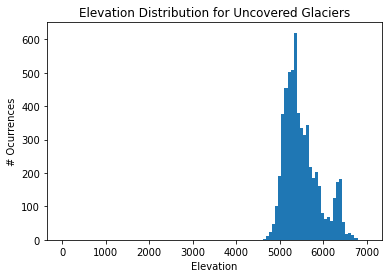

In [ ]:
calculate_raster_histogram(rasterfile,histogram_file, bins, min, max, title, xlabel, ylabel)

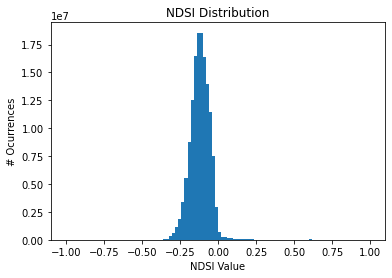

In [ ]:
#NDSI Histogram
rasterfile = "/content/drive/MyDrive/UVA - Information Studies/Thesis/Data/Thesis_Data/Satellite Scenes/13FEB15/NDSI_QGIS.TIF"
histogram_file = "/content/drive/MyDrive/UVA - Information Studies/Thesis/Data/Thesis_Data/Satellite Scenes/13FEB15/NDSI_QGIS_histogram.png"
calculate_raster_histogram(rasterfile,histogram_file, bins=100, min=-1, max=1, title='NDSI Distribution', xlabel = 'NDSI Value', ylabel = '# Ocurrences')

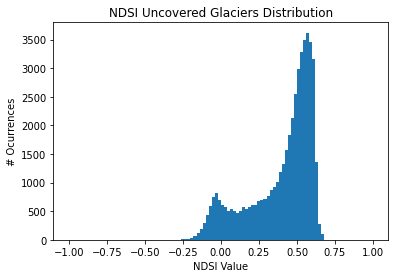

In [ ]:
#NDSI UG Histogram
rasterfile = "/content/drive/MyDrive/UVA - Information Studies/Thesis/Data/Thesis_Data/Satellite Scenes/13FEB15/NDSI_QGIS_UG.tif"
histogram_file = "/content/drive/MyDrive/UVA - Information Studies/Thesis/Data/Thesis_Data/Satellite Scenes/13FEB15/NDSI_QGIS_UG_histogram.png"
calculate_raster_histogram(rasterfile,histogram_file, bins=100, min=-1, max=1, title='NDSI Uncovered Glaciers Distribution', xlabel = 'NDSI Value', ylabel = '# Ocurrences')

##Shapefile Histograms 

In [ ]:
inputfile = "/content/drive/MyDrive/UVA - Information Studies/Thesis/Data/Thesis_Data/Shapefiles/Cryosphere/Original/criosfera_atacama.shp"
driver = ogr.GetDriverByName('ESRI Shapefile')
dataset = driver.Open(inputfile)
layer = dataset.GetLayer()

In [ ]:
layer.GetExtent()

(356193.2293418992, 572954.114626585, 6709753.068106454, 7202682.828589642)

In [ ]:
layer.ResetReading() #need if looping again

#Create Lists
orientation_list = []
slope_list = []
surface_list = []
ratio_list = []

feature = layer.GetNextFeature()
while feature:
  if feature.GetField('CLASE') == 'Glaciar descubierto':
    
    #orientation
    orientation_list.append(feature.GetField('ORIEN_MEAN'))
    
    #slope
    slope_list.append(feature.GetField('PEN_MEAN'))
    
    #area (or surface)
    surface_list.append(feature.GetField('AREA'))

    #ratio between a circular perimeter vs the real perimeter.
    p_real = feature.GetField('PERÍMETRO')
    p_ring = (4*math.pi*feature.GetField('AREA'))**(1/2)
    ratio_list.append(p_ring/p_real)

  feature = layer.GetNextFeature()

#Lists to arrays
orientation_array = np.array(orientation_list)
slope_array = np.array(slope_list)
surface_array = np.array(surface_list)
ratio_array = np.array(ratio_list)

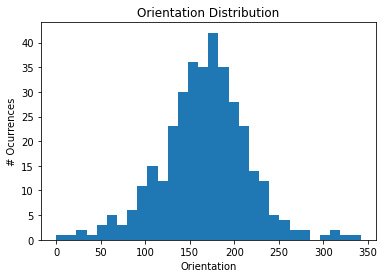

In [ ]:
histogram_file = "/content/drive/MyDrive/UVA - Information Studies/Thesis/Data/Thesis_Data/Shapefiles/Cryosphere/Original/criosfera_atacama_orientation_histogram.png"
calculate_histogram(orientation_array, histogram_file, bins=30, min=None, max=None, title="Orientation Distribution", xlabel="Orientation", ylabel="# Ocurrences")

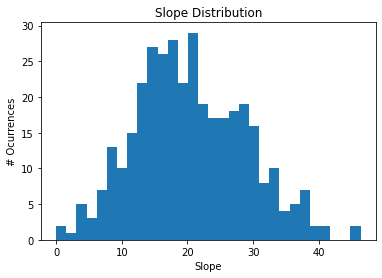

In [ ]:
histogram_file = "/content/drive/MyDrive/UVA - Information Studies/Thesis/Data/Thesis_Data/Shapefiles/Cryosphere/Original/criosfera_atacama_slope_histogram.png"
calculate_histogram(slope_array, histogram_file, bins=30, min=None, max=None, title="Slope Distribution", xlabel="Slope", ylabel="# Ocurrences")

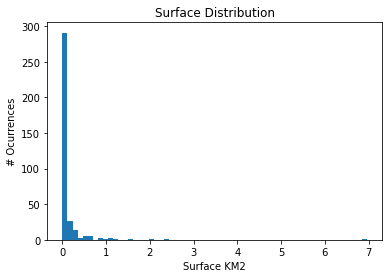

In [ ]:
histogram_file = "/content/drive/MyDrive/UVA - Information Studies/Thesis/Data/Thesis_Data/Shapefiles/Cryosphere/Original/criosfera_atacama_surface_histogram.png"
calculate_histogram(surface_array, histogram_file, bins=60, min=None, max=None, title="Surface Distribution", xlabel="Surface KM2", ylabel="# Ocurrences")

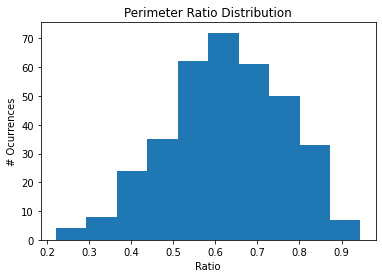

In [ ]:
histogram_file = "/content/drive/MyDrive/UVA - Information Studies/Thesis/Data/Thesis_Data/Shapefiles/Cryosphere/Original/criosfera_atacama_ratio_histogram.png"
calculate_histogram(ratio_array, histogram_file, bins=10, min=None, max=None, title="Perimeter Ratio Distribution", xlabel="Ratio", ylabel="# Ocurrences")

#Dataset Building

##Functions

In [ ]:
def shapefile_data_to_df(shapefile):
  driver = ogr.GetDriverByName('ESRI Shapefile')
  dataset = driver.Open(shapefile)
  layer = dataset.GetLayer()
  layer.ResetReading() #need if looping again
  feature = layer.GetNextFeature()

  i=0

  while feature:
    
    df1 = pd.DataFrame(feature.items(), index=[i])
    
    if i == 0:
      df2 = df1
    
    else:
      df2 = df2.append(df1)
    
    i = i+1
    feature = layer.GetNextFeature()

  #df2.reset_index(inplace=True)
  
  driver = None
  dataset = None
  layer = None
  feature = None

  return df2


In [ ]:
def shapefile_data_to_csv(shapefile):
  df = shapefile_data_to_df(shapefile)
  csv_file = shapefile.rsplit(sep=".",maxsplit=1)[0]
  csv_file = csv_file + '.csv'
  df.to_csv(csv_file)
  return 1

In [ ]:
def extract_by_extent(rasterfile,shapefile,output):
  rasterlayer = gdal.Open(rasterfile, gdal.GA_ReadOnly)
  
  driver = ogr.GetDriverByName('ESRI Shapefile')
  dataset = driver.Open(shapefile)
  layer = dataset.GetLayer()
  extent = layer.GetExtent()

  result = gdal.Translate(output, rasterlayer, 
                          projWin = [extent[0], extent[3], extent[1], extent[2]])
  driver = None
  rasterlayer = None
  dataset = None
  layer = None

  return result

In [ ]:
def extract_by_extent_fixed(rasterfile,shapefile,output,x,y):
  print(rasterfile)
  print(shapefile)
  rasterlayer = gdal.Open(rasterfile, gdal.GA_ReadOnly)
  
  gt = rasterlayer.GetGeoTransform()
  pixelSizeX = gt[1]
  pixelSizeY = -gt[5]

  print(gt)

  driver = ogr.GetDriverByName('ESRI Shapefile')
  dataset = driver.Open(shapefile)
  layer = dataset.GetLayer()
  extent = layer.GetExtent()

  ulx = extent[0] #521337.008193737 --> 519728.8314940506 OK aumento
  uly = extent[3] #-2995453.1303165336 --> -2996236.3231558353 OK?
  lrx = extent[1] #-2994985.901673741 --> -2993419.5159951374
  lry = extent[2] #521720.65479436424 --> 522524.7431442074

  print(ulx,uly,lrx,lry)

  print(((x*pixelSizeX - (lrx - ulx)) / 2))
  print(((y*pixelSizeY - (uly - lry)) / 2))

  ulx_new = ulx - ((x*pixelSizeX - (lrx - ulx)) / 2)
  lrx_new = lrx + ((x*pixelSizeX - (lrx - ulx)) / 2)
  uly_new = uly + ((y*pixelSizeY - (uly - lry)) / 2)
  lry_new = lry - ((y*pixelSizeY - (uly - lry)) / 2)

  print(ulx,uly,lrx,lry)

  result = gdal.Translate(output, rasterlayer, projWin = [ulx_new, uly_new, lrx_new, lry_new])
  
  driver = None
  rasterlayer = None
  dataset = None
  layer = None

  return result

In [ ]:
def extract_by_mask(rasterfile,shapefile,output):
  rasterlayer = gdal.Open(rasterfile, gdal.GA_ReadOnly)
  
  cols = rasterlayer.RasterXSize
  rows = rasterlayer.RasterYSize
  
  kwargs={'cutlineDSName':shapefile, 'width':cols, 'height':rows,'cropToCutline':False}
  result = gdal.Warp(output,rasterlayer,**kwargs)

  rasterlayer = None

  return result


In [ ]:
def mask_calculator(a, b):
    #a = pixel value in mask1
    #b = pixel value in mask2
    
    #examples
    #1) pixel in main glacier --> a > 0 and b > 0
    #2) pixel in surrounding glacier --> a > 1 and b = 0
    #3) non - ice pixel --> a = 0

    # non-ice pixel
    if a == 0:
        return 0
    
    else:
      # surrounding glacier
      if b == 0:
        return 2
      # main glacier
      else:
        return 1

vectorize_mask_function = np.vectorize(mask_calculator)

In [ ]:
def mask_calculator_2d(mask1, mask2):
    
    mask1 = np.where(mask1 > 0, 1, 0)
    mask2 = np.where(mask2 > 0, 1, 0)

    mask3 = mask1+mask2
    
    mask3 = np.where(mask3 == 1, 3, mask3) #sg to 3
    mask3 = np.where(mask3 == 2, 1, mask3) #mg to 1
    mask3 = np.where(mask3 == 3, 2, mask3) #sg to 2

    return mask3

In [ ]:
def calculate_mask(rasterfile1,rasterfile2, mask_output):

  #inputs:
  #rasterfile1: first raster file
  #rasterfile2: second raster file
  
  #considerations:
  #both raster files have the same size.
  #both raster files have the same driver.

  #read raster files
  rlayer1 = gdal.Open(rasterfile1, gdal.GA_ReadOnly)
  rlayer2 = gdal.Open(rasterfile2, gdal.GA_ReadOnly)

  #get # columns and rows and bands
  cols = rlayer1.RasterXSize
  rows = rlayer1.RasterYSize
  #bands = rlayer1.RasterCount
  
  #get Geo data
  geoTransform = rlayer1.GetGeoTransform()
  proj = rlayer1.GetProjection()

  #read first band
  band1 = rlayer1.GetRasterBand(1)
  band2 = rlayer2.GetRasterBand(1)

  #get numpy array
  array1 = band1.ReadAsArray(0, 0, cols, rows)
  array2 = band2.ReadAsArray(0, 0, cols, rows)

  #calculate mask
  #mask = vectorize_mask_function(array1, array2)
  mask = mask_calculator_2d(array1, array2)
  

  #get driver to write
  driver = rlayer1.GetDriver()

  #create output raster
  outDataset = driver.Create(mask_output, cols, rows, 1, gdal.GDT_Float32)
  outDataset.SetGeoTransform(geoTransform)
  outDataset.SetProjection(proj)

  # get band for out dataset
  outBand = outDataset.GetRasterBand(1)

  #write ndsi
  outBand.WriteArray(mask, 0, 0)

  #set all to null for memory purposes
  rlayer1 = None
  rlayer2 = None
  band1 = None
  band2 = None
  array1 = None
  array2 = None
  ndsi = None
  driver = None
  outDataset = None
  outBand = None

  return 1

## Shapefile data to CSV

In [ ]:
shapefile = "/content/drive/MyDrive/Thesis_Data/Shapefiles/Cryosphere/UG_32619_fixed_geometry/UG_32619.shp"
shapefile_data_to_csv(shapefile)

Shapefile data saved


##Individual glacier rasters (X) (All bands!)

In [ ]:
#lists of bands, buffers and glaciers
bands = ['B1']
buffers = ['Buffer_0']
glaciers = list(range(108,109))
glaciers  = ["Number_" + str(s) for s in glaciers]
print(glaciers)

#location of files
bands_folder = '/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/'
#bands_folder = '/content/drive/MyDrive/Thesis_Data/DEM/ASTER/ASTER_32619_ALIGNED/'
shapefiles_folder = '/content/drive/MyDrive/Thesis_Data/Shapefiles/Cryosphere/UG_32619_fixed_geometry/'

['Number_108']


In [ ]:
for band in bands:
  for buffer in buffers:
    for glacier in glaciers:
      
      #step 1
      rasterfile = bands_folder + band + '/' + band + '.TIF'
      #print(rasterfile)
      shapefile = shapefiles_folder + buffer + '/split/' + glacier + '.shp'
      #print(shapefile)
      output = bands_folder + band + '/' + band + '_' + buffer + '_' + glacier + '.tif'
      print(output)
      #output = '/content/' + band + '_' + buffer + '_' + glacier + '.TIF'
      #print(output)
      #shapefile_data_to_csv(shapefile)
      try:
        #result = extract_by_extent(rasterfile,shapefile,output)
        result = extract_by_extent_fixed(rasterfile,shapefile,output,120,120)
      except:
        print("Band " + band + "- Buffer " + buffer + "- Glacier " + glacier + ": Fail (1)")
        continue

      if result is None:
        print("Band " + band + " - Buffer " + buffer + " - Glacier " + glacier + ": Fail (2)")
      else:
        print("Band " + band + " - Buffer " + buffer + " - Glacier " + glacier + ": Success")

##Individual Glacier Mask (Y) (Only 1 band)

In [ ]:
#lists of bands, buffers and glaciers
bands = ['B2']
buffers = ['Buffer_0','Buffer_P15']
glaciers = list(range(1,357))
glaciers  = ["Number_" + str(s) for s in glaciers]
print(glaciers)

#location of files
bands_folder = '/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/'
shapefiles_folder = '/content/drive/MyDrive/Thesis_Data/Shapefiles/Cryosphere/UG_32619_fixed_geometry/'
temp_file = '/content/temp.tif'
temp_file2 = '/content/temp2.tif'

['Number_1', 'Number_2', 'Number_3', 'Number_4', 'Number_5', 'Number_6', 'Number_7', 'Number_8', 'Number_9', 'Number_10', 'Number_11', 'Number_12', 'Number_13', 'Number_14', 'Number_15', 'Number_16', 'Number_17', 'Number_18', 'Number_19', 'Number_20', 'Number_21', 'Number_22', 'Number_23', 'Number_24', 'Number_25', 'Number_26', 'Number_27', 'Number_28', 'Number_29', 'Number_30', 'Number_31', 'Number_32', 'Number_33', 'Number_34', 'Number_35', 'Number_36', 'Number_37', 'Number_38', 'Number_39', 'Number_40', 'Number_41', 'Number_42', 'Number_43', 'Number_44', 'Number_45', 'Number_46', 'Number_47', 'Number_48', 'Number_49', 'Number_50', 'Number_51', 'Number_52', 'Number_53', 'Number_54', 'Number_55', 'Number_56', 'Number_57', 'Number_58', 'Number_59', 'Number_60', 'Number_61', 'Number_62', 'Number_63', 'Number_64', 'Number_65', 'Number_66', 'Number_67', 'Number_68', 'Number_69', 'Number_70', 'Number_71', 'Number_72', 'Number_73', 'Number_74', 'Number_75', 'Number_76', 'Number_77', 'Number

In [ ]:
for band in bands: 
  for buffer in buffers:
    #step 2.1
    rasterfile = bands_folder + band + '/' + band + '.TIF'
    shapefile_ug = shapefiles_folder + buffer + '/' + buffer + '.shp'
    
    try:
      result = extract_by_mask(rasterfile,shapefile_ug,temp_file)
    except:
      print(rasterfile)
      print(shapefile_ug)
      print("Band " + band + " - Buffer " + buffer + " - Step 2.1: Fail (1)")
      continue
    
    if result is None:
      print("Band " + band + " - Buffer " + buffer + " - Step 2.1: Fail (2)")
    else:
      print("Band " + band + " - Buffer " + buffer + " - Step 2.1: Success")  
  
    for glacier in glaciers:
      
      #step 2.2
      shapefile = shapefiles_folder + buffer + '/split/' + glacier + '.shp'
      mask1 = bands_folder + band + '/' + band + '_' + buffer + '_' + glacier + '_Mask1.tif'
      
      try:
        result = extract_by_extent(temp_file, shapefile, mask1)
      except:
        print("Band " + band + " - Buffer " + buffer + " - Glacier " + glacier + " - Step 2.2: Fail (1)")
        continue
      
      if result is None:
        print("Band " + band + " - Buffer " + buffer + " - Glacier " + glacier + " - Step 2.2: Fail (2)")
      else:
        print("Band " + band + " - Buffer " + buffer + " - Glacier " + glacier + " - Step 2.2: Success")

      #step 3.1
      try:
        result = extract_by_mask(rasterfile, shapefile, temp_file2)
      except:
        print("Band " + band + " - Buffer " + buffer + " - Glacier " + glacier + " - Step 3.1: Fail (1)")
        continue
      if result is None:
        print("Band " + band + " - Buffer " + buffer + " - Glacier " + glacier + " - Step 3.1: Fail (2)")
      else:
        print("Band " + band + " - Buffer " + buffer + " - Glacier " + glacier + " - Step 3.1: Success")

      #step 3.2
      mask2 = bands_folder + band + '/' + band + '_' + buffer + '_' + glacier + '_Mask2.tif'
      try:
        result = extract_by_extent(temp_file2,shapefile, mask2)
      except:
        print("Band " + band + " - Buffer " + buffer + " - Glacier " + glacier + " - Step 3.2: Fail (1)")
        continue

      if result is None:
        print("Band " + band + " - Buffer " + buffer + " - Glacier " + glacier + " - Step 3.2: Fail (2)")
      else:
        print("Band " + band + " - Buffer " + buffer + " - Glacier " + glacier + " - Step 3.2: Success")

      os.remove(temp_file2)

      #step 4
      mask3 = bands_folder + band + '/' + band + '_' + buffer + '_' + glacier + '_Mask3.tif'
      try:
        #print(mask1,mask2,mask3)
        result = calculate_mask(mask1,mask2,mask3)
      except:
        print("Band " + band + " - Buffer " + buffer + " - Glacier " + glacier + " - Step 4: Fail (1)")
        continue
      
      if result == 1:
        print("Band " + band + " - Buffer " + buffer + " - Glacier " + glacier + " - Step 4: Success")
      else:
        print("Band " + band + " - Buffer " + buffer + " - Glacier " + glacier + " - Step 4: Fail (2)")
      
    os.remove(temp_file)
    rasterfile = None


#Dataset Independency

In [ ]:
def glacier_vector2(rasterfile):
  
  #get the number of the main glacier
  number = rasterfile.rsplit(".")[0]
  number = number.rsplit("/")[-1]
  number = number.rsplit("_")[-1]
  number = int(number)

  #read raster, band and array
  rasterlayer = gdal.Open(rasterfile, gdal.GA_ReadOnly)
  band = rasterlayer.GetRasterBand(1)
  array = band.ReadAsArray(0, 0, 120, 120)

  #get uniquie values from array
  values, counts = np.unique(array, return_counts=True)
  #filter no data values (-99999), positive values and the main glacier
  bool_array = [(values < 0) & (values != -99999)]# & (values != -number)]
  values = values[tuple(bool_array)]
  counts = counts[tuple(bool_array)]

  #change to positive values
  values = values.astype(int) * -1

  #put everything in dictionary
  d = {}
  for value, count in zip(values, counts):
      d[value] = count

  #move main glacier to first position
  main_glacier_dict = {number: d.pop(number)}
  main_glacier_dict.update(d)

  #make final dictionary
  dic = {number:main_glacier_dict}
  return dic

def remove_glacier_in_vectors(glaciers_dict:dict, remove_glacier:int):
  
  for main_glacier in list(glaciers_dict): #{54 :{54:10, 55:2}, 57:{57:3, 58:4} } -- list =  54 and 57  
    
    #get vector
    vector = glaciers_dict[main_glacier] # {54:10, 55:2}

    if remove_glacier in vector:
      glaciers_dict.pop(main_glacier)
  
  return glaciers_dict

In [ ]:
#lists of bands, buffers and glaciers
glaciers = list(range(1,357))
glaciers  = ["Number_" + str(s) for s in glaciers]
#print(glaciers)

#location of files
input_directory = '/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/AtacamaRegion/B1_GN/'

1) build dictionary for each main glacier

In [ ]:
all_glaciers = {}
for subdir, dirs, files in os.walk(input_directory):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith(".tif") or filepath.endswith(".TIF"):
            if any(glacier+'.tif' in filepath for glacier in glaciers):        
                #get glacier vector with function
                glacier_vector = glacier_vector2(filepath)
                all_glaciers.update(glacier_vector)

print("Total:" + str(len(all_glaciers)))
#all_glaciers = {mg1 : {mg1:pixels, sg1:pixel2, sg2:pixels... }, mg2 : {mg2:pixels, sg1:pixels...} ... }

Total:356


2) get isolated vectors

In [ ]:
isolated_glaciers = {}
for glacier,vector in all_glaciers.items():
    if len(vector) == 1:
        isolated_glaciers.update({glacier:vector})

print("Isolated:" + str(len(isolated_glaciers)))

Isolated:13


3) get non isolated glacier that don't contain the isolated glaciers

In [ ]:
non_isolated_glaciers = {}
dropped_non_isolated_glaciers = {}

for glacier,vector in all_glaciers.items():
    if len(vector) > 1:
        if not any(isolated_glacier in vector for isolated_glacier in isolated_glaciers):
            non_isolated_glaciers.update({glacier:vector})
        else:
            dropped_non_isolated_glaciers.update({glacier:vector})

print("Non Isolated: " + str(len(non_isolated_glaciers)))
print("Non Isolated Dropped: " + str(len(dropped_non_isolated_glaciers)))

Non Isolated: 342
Non Isolated Dropped: 1


4) read shapefile csv file with areas of different glaciers

In [ ]:
df_shapefile = pd.read_csv('/content/drive/MyDrive/Thesis_Data/Shapefiles/Cryosphere/UG_32619_fixed_geometry/Buffer_0/Buffer_0.csv')
df_shapefile = df_shapefile[['Number','AREA']]
df_shapefile.head()

Number      AREA
0       1  0.025607
1       2  0.018420
2       3  0.144810
3       4  0.060998
4       5  0.014035

5) Get Square difference for each main glacier image

In [ ]:
for main_glacier, vector in non_isolated_glaciers.items():
    
    #example main_glacier = 56
    #vector = {56:10, 57:11}

    #get surface pixel area
    sum_of_squared_dif = 0
    sum_pixel_area = 0 
    sum_shapefile_area = 0

    for glacier, pixels in vector.items():
        
        #glacier = 56
        #pixel = 10

        #pixel area km2
        pixel_area = 30/1000 * 30/1000 * pixels
        #real area from shapefile
        shapefile_area = df_shapefile[df_shapefile['Number'] == glacier]['AREA'].values[0]
        #get squared diference
        sq_dif = (pixel_area-shapefile_area)**2
        
        #sum
        sum_pixel_area = sum_pixel_area + pixel_area
        sum_shapefile_area = sum_shapefile_area + shapefile_area
        sum_of_squared_dif = sum_of_squared_dif + sq_dif

    data = {"main_glacier": [main_glacier], "sum_pixel_area":[sum_pixel_area], "sum_shapefile_area":[sum_shapefile_area], "sum_of_squared_dif":[sum_of_squared_dif]}
    
    try: 
        df_areas = df_areas.append(pd.DataFrame(data))
    except:
        df_areas = pd.DataFrame(data)

df_areas.reset_index(drop=True,inplace=True)
df_areas = df_areas.sort_values(by=['sum_of_squared_dif'], ascending=True)
df_areas.head(5)

main_glacier  sum_pixel_area  sum_shapefile_area  sum_of_squared_dif
12             34          0.0324            0.032105        3.433298e-07
170           182          0.1116            0.110833        6.735266e-07
200           180          0.1116            0.110833        6.735266e-07
149           179          0.1116            0.110833        6.735266e-07
160           181          0.1116            0.110833        6.735266e-07

6) Select non isolated glaciers:

In [ ]:
#Iterate over df_areas, selecting best main_glaciers
selected_non_isolated_glaciers = {}

for index, row in df_areas.iterrows():
    
    search_glacier = row['main_glacier'].astype(int) #54
    
    #try to pop the searched glacier
    try:
        pop = non_isolated_glaciers.pop(search_glacier)

        #if we popped the searched glacier: 
        if pop:

            #we add it to the non_isolated_glaciers
            selected_non_isolated_glaciers.update({search_glacier:pop})
            
            #we have to remove all the images that include any of the surrounding glaciers or the main glacier
            for glacier, pixels in pop.items():
                non_isolated_glaciers = remove_glacier_in_vectors(non_isolated_glaciers, glacier)
    
    #Else, we remove all the images that include the searched glaciers
    except:
         non_isolated_glaciers = remove_glacier_in_vectors(non_isolated_glaciers, search_glacier)

print("Non Isolated Selected: " + str(len(selected_non_isolated_glaciers)))


In [ ]:
selected_images = {**isolated_glaciers, **selected_non_isolated_glaciers} 
selected_images

In [ ]:
#create dictionary of glaciers and it's corresponding main_glacier/image
selected_glaciers = {}
for main_glacier, vector in selected_images.items():
  for glacier, pixel in vector.items():
   selected_glaciers.update({glacier:main_glacier})

len(selected_glaciers)


263

#Dataset Splitting


*   https://scikit-learn.org/stable/modules/cross_validation.html#stratification

*   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

*   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#examples-using-sklearn-model-selection-train-test-split

*   https://danilzherebtsov.medium.com/continuous-data-stratification-c121fc91964b

*   https://datascience.stackexchange.com/questions/78194/is-it-possible-to-have-stratified-train-test-split-of-a-set-based-on-two-columns

*   https://towardsdatascience.com/3-things-you-need-to-know-before-you-train-test-split-869dfabb7e50

*   https://www.kdnuggets.com/2020/05/dataset-splitting-best-practices-python.html

*   https://www.kite.com/python/answers/how-to-fit-data-to-a-distribution-in-python

*   https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

*   https://pythonhealthcare.org/2018/05/03/81-distribution-fitting-to-data/

*   https://es.wikipedia.org/wiki/Normalizaci%C3%B3n_(estad%C3%ADstica)

*   https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test

*   https://en.wikipedia.org/wiki/Goodness_of_fit

*   https://www.statisticshowto.com/kolmogorov-smirnov-test/

*   https://www.itl.nist.gov/div898/handbook/eda/section3/eda35g.htm

*   https://www.spss-tutorials.com/spss-kolmogorov-smirnov-test-for-normality/

*   https://www.real-statistics.com/non-parametric-tests/goodness-of-fit-tests/two-sample-kolmogorov-smirnov-test/

*   http://www.stats.ox.ac.uk/~massa/Lecture%2013.pdf

Read Glaciar Shapefile Data

In [ ]:
df_ug = pd.read_csv("/content/drive/MyDrive/Thesis_Data/Shapefiles/Cryosphere/UG_32619_fixed_geometry/UG_32619.csv")
df_ug = df_ug[['AREA','RatioPeri','Number']]
df_ug.head()

AREA  RatioPeri  Number
0  0.025607    0.73970       1
1  0.018420    0.83974       2
2  0.144810    0.71148       3
3  0.060998    0.70836       4
4  0.014035    0.56736       5

##Theoretical distributions


Function to get the best theoretical distribution

In [ ]:
# different kind of distribution available in Python
namedistrib1 = [scipy.stats.alpha,scipy.stats.anglit,scipy.stats.arcsine,scipy.stats.argus,scipy.stats.beta,scipy.stats.betaprime,scipy.stats.bradford,scipy.stats.burr,scipy.stats.burr12,scipy.stats.cauchy,scipy.stats.chi,scipy.stats.chi2,scipy.stats.cosine,scipy.stats.crystalball,scipy.stats.dgamma,scipy.stats.dweibull,scipy.stats.erlang,scipy.stats.expon,scipy.stats.exponnorm,scipy.stats.exponweib,scipy.stats.exponpow,scipy.stats.f,scipy.stats.fatiguelife,scipy.stats.fisk,scipy.stats.foldcauchy,scipy.stats.foldnorm,scipy.stats.genlogistic,scipy.stats.gennorm,scipy.stats.genpareto,scipy.stats.genexpon,scipy.stats.genextreme,scipy.stats.gausshyper,scipy.stats.gamma,scipy.stats.gengamma,scipy.stats.genhalflogistic,scipy.stats.gilbrat,scipy.stats.gompertz,scipy.stats.gumbel_r,scipy.stats.gumbel_l,scipy.stats.halfcauchy,scipy.stats.halflogistic,scipy.stats.halfnorm,scipy.stats.halfgennorm,scipy.stats.hypsecant,scipy.stats.invgamma,scipy.stats.invgauss,scipy.stats.invweibull,scipy.stats.johnsonsb,scipy.stats.johnsonsu,scipy.stats.kappa4,scipy.stats.kappa3,scipy.stats.ksone,scipy.stats.kstwobign,scipy.stats.laplace,scipy.stats.levy,scipy.stats.levy_l,scipy.stats.logistic,scipy.stats.loggamma,scipy.stats.loglaplace,scipy.stats.lognorm,scipy.stats.lomax,scipy.stats.maxwell,scipy.stats.mielke,scipy.stats.moyal,scipy.stats.nakagami,scipy.stats.ncx2,scipy.stats.ncf,scipy.stats.nct,scipy.stats.norm,scipy.stats.norminvgauss,scipy.stats.pareto,scipy.stats.pearson3,scipy.stats.powerlaw,scipy.stats.powerlognorm,scipy.stats.powernorm,scipy.stats.rdist,scipy.stats.rayleigh,scipy.stats.rice,scipy.stats.recipinvgauss,scipy.stats.semicircular,scipy.stats.skewnorm,scipy.stats.t,scipy.stats.triang,scipy.stats.truncexpon,scipy.stats.truncnorm,scipy.stats.tukeylambda,scipy.stats.uniform,scipy.stats.vonmises,scipy.stats.vonmises_line,scipy.stats.wald,scipy.stats.weibull_min,scipy.stats.weibull_max,scipy.stats.wrapcauchy]

# string related to the different distribution available in Python
namedistrib2 = ['alpha','anglit','arcsine','argus','beta','betaprime','bradford','burr','burr12','cauchy','chi','chi2','cosine','crystalball','dgamma','dweibull','erlang','expon','exponnorm',
'exponweib','exponpow','f','fatiguelife','fisk','foldcauchy','foldnorm','genlogistic','gennorm','genpareto','genexpon','genextreme','gausshyper','gamma','gengamma','genhalflogistic',
'gilbrat','gompertz','gumbel_r','gumbel_l','halfcauchy','halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss','invweibull','johnsonsb','johnsonsu','kappa4',
'kappa3','ksone','kstwobign','laplace','levy','levy_l','logistic','loggamma','loglaplace','lognorm','lomax','maxwell','mielke','moyal',
'nakagami','ncx2','ncf','nct','norm','norminvgauss','pareto','pearson3','powerlaw','powerlognorm','powernorm','rdist','rayleigh','rice','recipinvgauss','semicircular','skewnorm','t',
'triang','truncexpon','truncnorm','tukeylambda','uniform','vonmises','vonmises_line','wald','weibull_min','weibull_max','wrapcauchy']

In [ ]:
len(namedistrib2)

93

In [ ]:
def get_best_distribution(df):
  
  stat=[]
  i = 0

  for distribution in namedistrib1 :  
    b = distribution.fit(df)	# first it is needed to fit the data according to the distribution
    res = scipy.stats.kstest(df,namedistrib2[i],args=b)	# then to evaluate the goodness of the fit according to the Kolmogorov-Smirnov test
    stat.append(res.pvalue)	# pvalue will be the estimator of the goodness of the fit (the higher, the better)
    i = i+1

  stat = np.array(stat)
  #position = np.where(stat == np.nanmax(stat))	# determination of the highest value of pvalue and thus to the best distribution
  #position = np.nanargmax(stat)
  return stat


###Area

In [ ]:
stats_area = get_best_distribution(df_ug['AREA'])

In [ ]:
print('BEST DISTRIBUTION : ' + namedistrib2[np.nanargmax(stats_area)] + ' /  Performance index : ' + str(stats_area[np.nanargmax(stats_area)]))

BEST DISTRIBUTION : powerlognorm /  Performance index : 0.979333517292624


In [ ]:
#area's theoretical distribution
area_td = namedistrib1[np.nanargmax(stats_area)].fit(df_ug['AREA'])
area_td

(0.03473485776833245,
 0.4006141687462398,
 -6.462367030750547e-05,
 0.002647171895355565)

Plot histogram and PDF

In [ ]:
binsnumber=40
area_array = np.array(df_ug['AREA'])
#area_array = normalize(area_array.reshape(1,-1),norm='max')
histx , histy = np.histogram(area_array,bins=binsnumber)
x = np.linspace(area_array.min(),area_array.max(),num=40)	# the plot of the distribution needs to respect the intervals and bins of the histogram

In [ ]:
area_pdf = namedistrib1[np.nanargmax(stats_area)].pdf(x,*area_td)

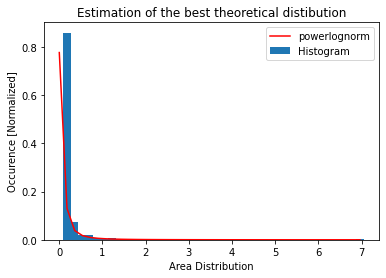

In [ ]:
plt.bar(histy[1:],histx*(1/np.sum(histx)),width=0.99*(histy[1]-histy[0]),label='Histogram')
plt.plot(x,area_pdf*(1/np.sum(area_pdf)),'r-',label=namedistrib2[np.nanargmax(stats_area)])

plt.xlabel('Area Distribution')
plt.ylabel('Occurence [Normalized]')
plt.title('Estimation of the best theoretical distibution')
plt.legend()

plt.show()

###RatioPeri

In [ ]:
stats_rp = get_best_distribution(df_ug['RatioPeri'])

In [ ]:
print('BEST DISTRIBUTION : ' + namedistrib2[np.nanargmax(stats_rp)] + ' /  Performance index : ' + str(stats_rp[np.nanargmax(stats_rp)]))


BEST DISTRIBUTION : weibull_max /  Performance index : 0.9819629682146634


In [ ]:
#ratioperi's theoretical distribution
ratioperi_td = namedistrib1[np.nanargmax(stats_rp)].fit(df_ug['RatioPeri'])
ratioperi_td

(2.7860303056624613, 0.9785531333578124, 0.39777987264814774)

Plot histogram and PDF

In [ ]:
position = np.nanargmax(stats_rp)
stats_rp2 = stats_rp.copy()
stats_rp2[position] = 0

for i in range(0,19) :
  positioni = np.nanargmax(stats_rp2)
  print('DISTRIBUTION ' + str(int(i+1)) + ' : ' + namedistrib2[positioni] + ' /  Performance index : ' + str(stats_rp2[positioni]))
  stats_rp2[positioni] = 0

In [ ]:
rp_array = np.array(df_ug['RatioPeri'])
#rp_array = normalize(rp_array.reshape(1,-1),norm='max')
histx, histy = np.histogram(rp_array,bins=binsnumber)
x = np.linspace(rp_array.min(),rp_array.max(),num=binsnumber)	# the plot of the distribution needs to respect the intervals and bins of the histogram

In [ ]:
rp_pdf = namedistrib1[np.nanargmax(stats_rp)].pdf(x,*ratioperi_td)

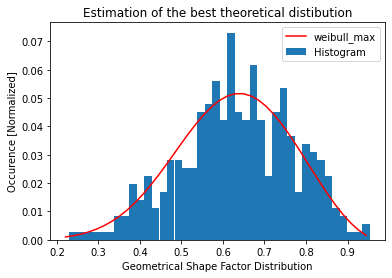

In [ ]:
plt.bar(histy[1:],histx*(1/np.sum(histx)),width=0.99*(histy[1]-histy[0]),label='Histogram')
plt.plot(x,rp_pdf*(1/np.sum(rp_pdf)),'r-',label=namedistrib2[np.nanargmax(stats_rp)])

plt.xlabel('Geometrical Shape Factor Distribution')
plt.ylabel('Occurence [Normalized]')
plt.title('Estimation of the best theoretical distibution')
plt.legend()

plt.show()

## Splitting approach 1: random sampling from theoretical distribution



In [ ]:
def sample_glaciers(df,amount):
  
  selection_list = []
  for i in range(1,amount+1): 
    #draw a random area and random ratio_peri according to the theoretical distribution
    area = scipy.stats.powerlognorm.rvs(*area_td)
    ratio_peri = scipy.stats.weibull_max.rvs(*ratioperi_td)
    
    #get euclidean distance of draw values and all the areas and ratioperi of the glaciers
    df['difference'] = np.sqrt(np.square(df['AREA']-area)+np.square(df['RatioPeri']-ratio_peri))
    
    #get index of glacier with the smallest distance
    selected_index = df['difference'].idxmin() #glacier number x is the closest one to the sample variable
    
    #add index to list
    selection_list.append(selected_index)

    df.drop(selected_index, inplace=True) #remove selected glacier from dataframe
  
  return selection_list

In [ ]:
def sample_glaciers2(df, amount:int, selected_glaciers:dict, selected_images:dict):
  
  sampled_images_list = []
  i=0

  while i < amount: 
    #draw a random area and random ratio_peri according to the theoretical distribution
    area = scipy.stats.powerlognorm.rvs(*area_td)
    ratio_peri = scipy.stats.weibull_max.rvs(*ratioperi_td)
    
    #get euclidean distance of draw values and all the areas and ratioperi of the glaciers
    df['difference'] = np.sqrt(np.square(df['AREA']-area)+np.square(df['RatioPeri']-ratio_peri))
    
    #get index of glacier with the smallest distance
    selected_index = df['difference'].idxmin() #glacier number x is the closest one to the sample variable
    selected_glacier = selected_index+1

    try:

      #get the asociated image, with all the glaciers included in image
      selected_image = selected_glaciers[selected_glacier] 

      #add index to list
      sampled_images_list.append(selected_images[selected_image])
    
      #remove selected glacier and surrounding glaciers from dataframe (example, image 5 includes glacier 4, 5 and 6)
      df.drop(df.index[df['Number'].isin(list(selected_images[selected_image]))], inplace=True)  

      #increase i by the amount of selected glaciers (example i = 0 + 3 = 3 + 15 = 18)
      i = i + len(list(selected_images[selected_image]))
    
    except:
      pass

  return sampled_images_list

Perform ks test comparing to the original distribution:

If the KS statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

One sample test:


*   H0: The data follow a specified distribution.
*   H1:	The data do not follow the specified distribution

If D > alpha  ---> Reject H0

Two sample test:


*   H0 = Distributions between samples are the same.
*   H1 = Distribution between samples aren't the same.

If D > alpha --> Reject H0


###Monte Carlo

In [ ]:
path = '/content/drive/MyDrive/Thesis_Data/Shapefiles/Cryosphere/UG_32619_fixed_geometry/'
#iterations_list = [100,200,300]
iterations_list = [100,200,300,400,500,600,700,800,900,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]
df_montecarlo = None

for iterations in iterations_list:
  
  best_p_value = 0

  with tqdm(total=iterations) as pbar:

    for i in range(1,iterations+1):
      df_aux = df_ug[df_ug['Number'].isin(list(selected_glaciers))].copy()

      #sample training set
      training_list = sample_glaciers2(df_aux, 210, selected_glaciers, selected_images)

      training_glaciers = [list(vector) for vector in training_list]
      training_glaciers = [item for sublist in training_glaciers for item in sublist]
      training_images = [list(vector.keys())[0] for vector in training_list]
      training_df = df_ug[df_ug['Number'].isin(training_glaciers)]
      
      #sample validation set
      validation_list = sample_glaciers2(df_aux, 26, selected_glaciers, selected_images)
      
      validation_glaciers = [list(vector) for vector in validation_list]
      validation_glaciers = [item for sublist in validation_glaciers for item in sublist]
      validation_images = [list(vector.keys())[0] for vector in validation_list]
      validation_df = df_ug[df_ug['Number'].isin(validation_glaciers)]
      
      #test sample is the rest of the glaciers
      test_df = df_aux[['AREA','RatioPeri','Number']].copy()
      test_images = [selected_glaciers[glacier] for glacier in list(test_df['Number'])]
      test_images = list(dict.fromkeys(test_images))

      area_training_stats = scipy.stats.ks_2samp(df_ug['AREA'],training_df['AREA'])
      rp_training_stats = scipy.stats.ks_2samp(df_ug['RatioPeri'],training_df['RatioPeri'])
      area_validation_stats = scipy.stats.ks_2samp(df_ug['AREA'],validation_df['AREA'])
      rp_validation_stats = scipy.stats.ks_2samp(df_ug['RatioPeri'],validation_df['RatioPeri'])
      area_test_stats = scipy.stats.ks_2samp(df_ug['AREA'],test_df['AREA'])
      rp_test_stats = scipy.stats.ks_2samp(df_ug['RatioPeri'],test_df['RatioPeri'])
      
      pvalue = area_training_stats[1]*rp_training_stats[1]*area_validation_stats[1]*rp_validation_stats[1]*area_test_stats[1]*rp_test_stats[1]

      #check if pvalue is better
      if pvalue > best_p_value:
        #update the best p value
        best_p_value = pvalue

        #save results in a dictonary
        data = {'Run':i,
                'Max_iterations': iterations,
                'Training_images': [training_images],
                'Training_glaciers': [list(training_df['Number'])],
                'Training_area_pvalue': area_training_stats[1],
                'Training_ratioperi_pvalue': rp_training_stats[1],
                
                'Validation_images': [validation_images], 
                'Validation_glaciers': [list(validation_df['Number'])], 
                'Validation_area_pvalue': area_validation_stats[1],
                'Validation_ratioperi_pvalue': rp_validation_stats[1],
                
                'Test_images': [test_images], 
                'Test_glaciers': [list(test_df['Number'])], 
                'Test_area_pvalue': area_test_stats[1],
                'Test_ratioperi_pvalue': rp_test_stats[1],

                'final_pvalue': pvalue
                }
      pbar.update(1)

    try:
      #read montecarlo pickle
      df_montecarlo = pd.read_pickle(path+'df_montecarlo.pkl')
      #drop results from same iterations
      df_montecarlo.drop(df_montecarlo[df_montecarlo.Max_iterations == data['Max_iterations']].index, inplace=True)
      #append new results
      df_montecarlo = df_montecarlo.append(pd.DataFrame(data))
    
    #else we create the dataframe
    except:
      df_montecarlo = pd.DataFrame(data)

    #reset index and save the dataframe in pkl
    df_montecarlo.reset_index(drop=True, inplace=True)
    df_montecarlo.to_pickle(path + "df_montecarlo.pkl")

100%|██████████| 10000/10000 [23:01<00:00,  7.24it/s]


In [ ]:
#to recover work
df_montecarlo = pd.read_pickle('/content/drive/MyDrive/Thesis_Data/Shapefiles/Cryosphere/UG_32619_fixed_geometry/df_montecarlo.pkl')
df_montecarlo

Run  Max_iterations  ... Test_ratioperi_pvalue final_pvalue
0     89             100  ...              0.457668     0.160887
1     91             200  ...              0.847551     0.163907
2    230             300  ...              0.482297     0.300699
3    384             400  ...              0.849884     0.277902
4    355             500  ...              0.912710     0.425072
5    595             600  ...              0.679948     0.386286
6    197             700  ...              0.776824     0.532882
7    360             800  ...              0.949862     0.484177
8    257             900  ...              0.989551     0.736610
9    648            1000  ...              0.588672     0.374726
10   311            2000  ...              0.811547     0.661440
11  2768            3000  ...              0.469671     0.325855
12  1215            4000  ...              0.843778     0.553047
13  4277            5000  ...              0.975680     0.513636
14  5157            6000  ...              0.792539     0.515399
15   822            7000  ...              0.984639     0.720458
16  3511            8000  ...              0.884041     0.697971
17  6051            9000  ...              0.816034     0.562145
18  1368           10000  ...              0.973976     0.660337

[19 rows x 15 columns]

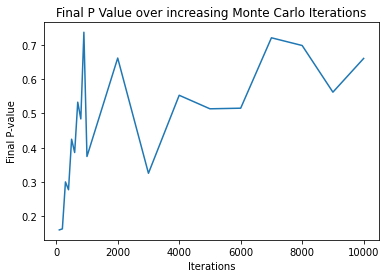

In [ ]:
plt.plot(df_montecarlo['Max_iterations'],df_montecarlo['final_pvalue'])
#plt.plot(np.array(df_montecarlo.index),df_montecarlo['final_pvalue'])
#plt.xscale("log")
plt.title('Final P Value over increasing Monte Carlo Iterations')
plt.xlabel('Iterations')
plt.ylabel('Final P-value')
plt.show()
#run for 60K, 70K, 80K 8 hours during the night, 90K and 100K?

In [ ]:
# df_mc = None
# for pkl in list_pkls:
#   try: 
#     df_mc = df_mc.append(pd.read_pickle(pkl))
#   except:
#     df_mc = pd.read_pickle(pkl)

# df_mc.reset_index(drop=True, inplace=True)

##Histograms of splitted sets

###Area

In [ ]:
#Get glaciers list
df_montecarlo = pd.read_pickle('/content/drive/MyDrive/Thesis_Data/Shapefiles/Cryosphere/UG_32619_fixed_geometry/df_montecarlo.pkl')
best_pvalue_index = df_montecarlo['final_pvalue'].idxmax()
df_montecarlo = df_montecarlo[df_montecarlo.index == best_pvalue_index]
df_montecarlo

Run  Max_iterations  ... Test_ratioperi_pvalue final_pvalue
8  257             900  ...              0.989551      0.73661

[1 rows x 15 columns]

Training set

In [ ]:
binsnumber=40
area_array = np.array(df_ug[df_ug['Number'].isin(list(df_montecarlo['Training_glaciers'])[0])]['AREA'])
histx , histy = np.histogram(area_array,bins=binsnumber)
x = np.linspace(area_array.min(),area_array.max(),num=40)	# the plot of the distribution needs to respect the intervals and bins of the histogram

In [ ]:
area_pdf = namedistrib1[np.nanargmax(stats_area)].pdf(x,*area_td)

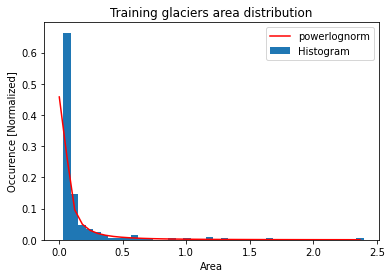

In [ ]:
plt.bar(histy[1:],histx*(1/np.sum(histx)),width=0.99*(histy[1]-histy[0]),label='Histogram')
plt.plot(x,area_pdf*(1/np.sum(area_pdf)),'r-',label=namedistrib2[np.nanargmax(stats_area)])

plt.xlabel('Area')
plt.ylabel('Occurence [Normalized]')
plt.title('Training glaciers area distribution')
plt.legend()

plt.show()

Validation set

In [ ]:
binsnumber=40
area_array = np.array(df_ug[df_ug['Number'].isin(list(df_montecarlo['Validation_glaciers'])[0])]['AREA'])
histx , histy = np.histogram(area_array,bins=binsnumber)
x = np.linspace(area_array.min(),area_array.max(),num=40)	# the plot of the distribution needs to respect the intervals and bins of the histogram

In [ ]:
area_pdf = namedistrib1[np.nanargmax(stats_area)].pdf(x,*area_td)

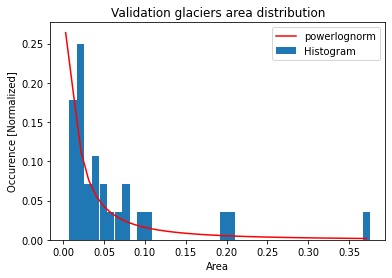

In [ ]:
plt.bar(histy[1:],histx*(1/np.sum(histx)),width=0.99*(histy[1]-histy[0]),label='Histogram')
plt.plot(x,area_pdf*(1/np.sum(area_pdf)),'r-',label=namedistrib2[np.nanargmax(stats_area)])

plt.xlabel('Area')
plt.ylabel('Occurence [Normalized]')
plt.title('Validation glaciers area distribution')
plt.legend()

plt.show()

Test set

In [ ]:
binsnumber=40
area_array = np.array(df_ug[df_ug['Number'].isin(list(df_montecarlo['Test_glaciers'])[0])]['AREA'])
histx , histy = np.histogram(area_array,bins=binsnumber)
x = np.linspace(area_array.min(),area_array.max(),num=40)	# the plot of the distribution needs to respect the intervals and bins of the histogram

In [ ]:
area_pdf = namedistrib1[np.nanargmax(stats_area)].pdf(x,*area_td)

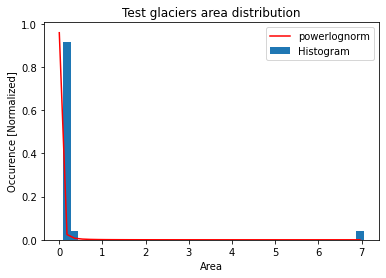

In [ ]:
plt.bar(histy[1:],histx*(1/np.sum(histx)),width=0.99*(histy[1]-histy[0]),label='Histogram')
plt.plot(x,area_pdf*(1/np.sum(area_pdf)),'r-',label=namedistrib2[np.nanargmax(stats_area)])

plt.xlabel('Area')
plt.ylabel('Occurence [Normalized]')
plt.title('Test glaciers area distribution')
plt.legend()

plt.show()

###Ratio Peri

Training set

In [ ]:
rp_array = np.array(df_ug[df_ug['Number'].isin(list(df_montecarlo['Training_glaciers'])[0])]['RatioPeri'])
histx, histy = np.histogram(rp_array,bins=binsnumber)
x = np.linspace(rp_array.min(),rp_array.max(),num=binsnumber)	# the plot of the distribution needs to respect the intervals and bins of the histogram

In [ ]:
rp_pdf = namedistrib1[np.nanargmax(stats_rp)].pdf(x,*ratioperi_td)

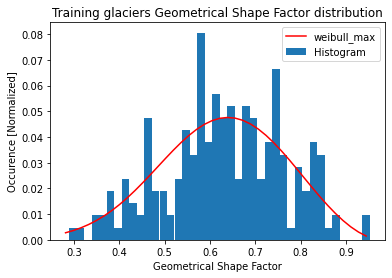

In [ ]:
plt.bar(histy[1:],histx*(1/np.sum(histx)),width=0.99*(histy[1]-histy[0]),label='Histogram')
plt.plot(x,rp_pdf*(1/np.sum(rp_pdf)),'r-',label=namedistrib2[np.nanargmax(stats_rp)])

plt.xlabel('Geometrical Shape Factor')
plt.ylabel('Occurence [Normalized]')
plt.title('Training glaciers Geometrical Shape Factor distribution')
plt.legend()

plt.show()

Validation Set

In [ ]:
rp_array = np.array(df_ug[df_ug['Number'].isin(list(df_montecarlo['Validation_glaciers'])[0])]['RatioPeri'])
histx, histy = np.histogram(rp_array,bins=binsnumber)
x = np.linspace(rp_array.min(),rp_array.max(),num=binsnumber)	# the plot of the distribution needs to respect the intervals and bins of the histogram

In [ ]:
rp_pdf = namedistrib1[np.nanargmax(stats_rp)].pdf(x,*ratioperi_td)

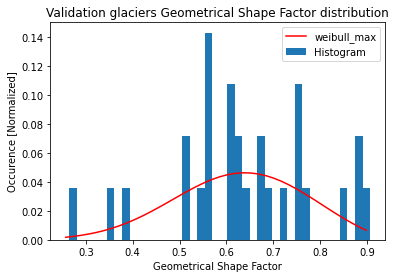

In [ ]:
plt.bar(histy[1:],histx*(1/np.sum(histx)),width=0.99*(histy[1]-histy[0]),label='Histogram')
plt.plot(x,rp_pdf*(1/np.sum(rp_pdf)),'r-',label=namedistrib2[np.nanargmax(stats_rp)])

plt.xlabel('Geometrical Shape Factor')
plt.ylabel('Occurence [Normalized]')
plt.title('Validation glaciers Geometrical Shape Factor distribution')
plt.legend()

plt.show()

Test Set

In [ ]:
rp_array = np.array(df_ug[df_ug['Number'].isin(list(df_montecarlo['Test_glaciers'])[0])]['RatioPeri'])
histx, histy = np.histogram(rp_array,bins=binsnumber)
x = np.linspace(rp_array.min(),rp_array.max(),num=binsnumber)	# the plot of the distribution needs to respect the intervals and bins of the histogram

In [ ]:
rp_pdf = namedistrib1[np.nanargmax(stats_rp)].pdf(x,*ratioperi_td)

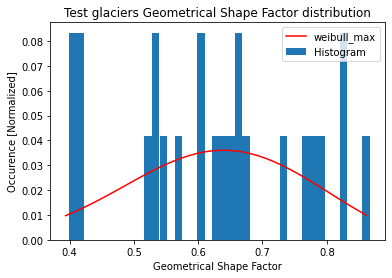

In [ ]:
plt.bar(histy[1:],histx*(1/np.sum(histx)),width=0.99*(histy[1]-histy[0]),label='Histogram')
plt.plot(x,rp_pdf*(1/np.sum(rp_pdf)),'r-',label=namedistrib2[np.nanargmax(stats_rp)])

plt.xlabel('Geometrical Shape Factor')
plt.ylabel('Occurence [Normalized]')
plt.title('Test glaciers Geometrical Shape Factor distribution')
plt.legend()

plt.show()

#Pixel Value Distribution

In [ ]:
directory = '/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/AtacamaRegion/All_channels'
array = 0
lis = []
  
with tqdm(total=len(list(selected_images))) as pbar:  
  
  #read directory and put images in a list
  for subdir, dirs, files in os.walk(directory):
    for filename in files:
      filepath = subdir + os.sep + filename
      if filename.endswith(".TIF"):
          if any('Number_'+str(image)+'.' in filename for image in list(selected_images)):
            #print(filepath)
            array_aux = imread(filepath)
            lis.append(array_aux)
            pbar.update(1)

#stack images in an array
array = np.stack(lis)
print(array.shape)

100%|██████████| 58/58 [00:11<00:00,  4.87it/s]

(58, 120, 120, 10)


In [ ]:
df_bands_stats = None
bands = ['B1','B2','B3','B4','B5','B6','B7','B10','ASTER','NDSI']

for i in range(0,array.shape[3]):
  band = array[:,:,:,i]
  band = np.ravel(band)
  band.shape

  #data = {'band':i,'mean': [band.mean()], 'std': [band.std()], 'max':[band.max()], 'min':[band.min()]}
  data = {'band': bands[i],'mean': [np.nanmean(band)], 'std': [np.nanstd(band)], 'max':[np.nanmax(band)], 'min':[np.nanmin(band)]}

  try:
    df_bands_stats = df_bands_stats.append(pd.DataFrame(data))

  #else we create the dataframe
  except:
    df_bands_stats = pd.DataFrame(data)

df_bands_stats.reset_index(drop=True, inplace=True)
df_bands_stats.to_csv('/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/All_bands/band_stats.csv',index=False)
df_bands_stats

band          mean           std           max       min
0     B1   9011.958008   4556.866211  44186.000000  0.000000
1     B2   9544.960938   4771.043945  45664.000000  0.000000
2     B3  10802.500000   5218.652344  46398.000000  0.000000
3     B4  11978.188477   5610.646973  46490.000000  0.000000
4     B5  12336.836914   5498.568848  42869.000000  0.000000
5     B6  12292.875977   5496.829102  32678.000000  0.000000
6     B7  11652.006836   5083.526855  32026.000000  0.000000
7    B10  37237.062500  14422.817383  48694.000000  0.000000
8  ASTER   4543.933594   1790.942261   6862.000000  0.000000
9   NDSI      0.058836      0.122209      0.534895 -0.677459

#Ice and non-ice Distribution

In [ ]:
import seaborn as sns

In [ ]:
#Get list of images to mosaic
directories = ['/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/Mask/2 Classes/Buffer_0/']
array = 0

with tqdm(total=356) as pbar:
  for directory in directories:
    for subdir, dirs, files in os.walk(directory):
      for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith(".tif"):# and ('Number_1_Mask' in filepath or 'Number_2_Mask' in filepath or 'Number_3_Mask' in filepath):
          array_aux = imread(filepath)
          try:
            array = np.append(array,array_aux)
          except:
            array = array_aux
          pbar.update(1)

100%|██████████| 356/356 [01:48<00:00,  3.27it/s]


In [ ]:
df_target = pd.DataFrame(data=array, columns=['Ice Pixel'])
df_target

In [ ]:
from matplotlib.ticker import FormatStrFormatter


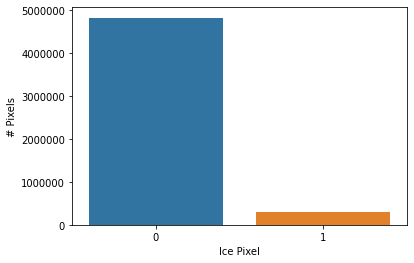

In [ ]:
ax = sns.countplot(x='Ice Pixel', data=df_target)
#ax = sns.barplot(x="Ice Pixel", y="Ice Pixel", data=df_target)
#ax = sns.barplot(x="Ice Pixel", y="Ice Pixel", data=df_target, estimator=lambda x: len(x) / len(df_target) * 100)
ax.set(ylabel = "# Pixels")
ax.ticklabel_format(style='plain', axis = 'y')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.show()

In [ ]:
df_target['Ice Pixel'].value_counts()

0.0    4825463
1.0     300938
Name: Ice Pixel, dtype: int64

In [ ]:
df_target['Ice Pixel'].value_counts()[0]/df_target['Ice Pixel'].value_counts()[1]

16.034741375299895

**Non-ice pixels are 15 times more frequent than ice pixels. This means we have an unbalance problem.**

In [ ]:
df_target['Ice Pixel'].value_counts()[1]/df_target['Ice Pixel'].count()

0.05870356220670213

**6% of the pixels are ice pixels. Again, this means we have an unbalance problem.**

# Deep Neural Network: Pytorch

##Libraries

In [ ]:
pip install torchgeometry &> /dev/null

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils import data
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn as nn
import torchgeometry as tgm
from torchsummary import summary
import torch.optim as optim
from matplotlib import colors

from skimage.transform import resize
from skimage.io import imread
from skimage.util import crop
from sklearn.externals._pilutil import bytescale
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, roc_auc_score, balanced_accuracy_score, roc_curve, confusion_matrix

from typing import List, Callable, Tuple

from functools import partial

import copy

import uuid

import albumentations


In [ ]:
pip install torchgeometry

##Parameters

In [ ]:
df_bands_stats = pd.read_csv('/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/All_bands/band_stats.csv')
df_bands_stats

band          mean           std           max       min
0     B1   9011.958008   4556.866211  44186.000000  0.000000
1     B2   9544.960938   4771.043945  45664.000000  0.000000
2     B3  10802.500000   5218.652344  46398.000000  0.000000
3     B4  11978.188477   5610.646973  46490.000000  0.000000
4     B5  12336.836914   5498.568848  42869.000000  0.000000
5     B6  12292.875977   5496.829102  32678.000000  0.000000
6     B7  11652.006836   5083.526855  32026.000000  0.000000
7    B10  37237.062500  14422.817383  48694.000000  0.000000
8  ASTER   4543.933594   1790.942261   6862.000000  0.000000
9   NDSI      0.058836      0.122209      0.534895 -0.677459

In [ ]:
#channels = ['B1','B2','B3','B4','B5','B6','B7','B10','ASTER','NDSI']
channels = ['B1','B2','B3','B4','B5','B6','B7','B10']
channel_stats = df_bands_stats[df_bands_stats['band'].isin(channels)].reset_index(drop = True)
channel_indices = list(df_bands_stats[df_bands_stats['band'].isin(channels)].index)
mask_buffer = 'Buffer_0' #'Buffer_0'

# criterion
# Options: dice score/f1, balanced accuracy, agregated jaccart index,focalloss, intersection of union (iou)
# criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
criterion = tgm.losses.DiceLoss()
# criterion = IoULoss()

learning_rate = 0.01 #Find one tha, #bigger batch bigger lr 
epochs=100 #depends on the amount of data, but 100 to 300 should be ok #Google early stop for pytorch

now = datetime.now()
today = now.strftime("%d%b%y").upper()

model_id = str(uuid.uuid4())

In [ ]:
channel_stats

band          mean           std      max  min
0   B1   9011.958008   4556.866211  44186.0  0.0
1   B2   9544.960938   4771.043945  45664.0  0.0
2   B3  10802.500000   5218.652344  46398.0  0.0
3   B4  11978.188477   5610.646973  46490.0  0.0
4   B5  12336.836914   5498.568848  42869.0  0.0
5   B6  12292.875977   5496.829102  32678.0  0.0
6   B7  11652.006836   5083.526855  32026.0  0.0
7  B10  37237.062500  14422.817383  48694.0  0.0

In [ ]:
channel_indices

[0, 1, 2, 3, 4, 5, 6, 7]

##UNET

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
# device
# if torch.cuda.is_available():
#     device = torch.device('cuda')
# else:
#     torch.device('cpu')


###unet.py

In [ ]:
@torch.jit.script
def autocrop(encoder_layer: torch.Tensor, decoder_layer: torch.Tensor):
    """
    Center-crops the encoder_layer to the size of the decoder_layer,
    so that merging (concatenation) between levels/blocks is possible.
    This is only necessary for input sizes != 2**n for 'same' padding and always required for 'valid' padding.
    """
    if encoder_layer.shape[2:] != decoder_layer.shape[2:]:
        ds = encoder_layer.shape[2:]
        es = decoder_layer.shape[2:]
        assert ds[0] >= es[0]
        assert ds[1] >= es[1]
        if encoder_layer.dim() == 4:  # 2D
            encoder_layer = encoder_layer[
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2)
                            ]
        elif encoder_layer.dim() == 5:  # 3D
            assert ds[2] >= es[2]
            encoder_layer = encoder_layer[
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2),
                            ((ds[2] - es[2]) // 2):((ds[2] + es[2]) // 2),
                            ]
    return encoder_layer, decoder_layer


def conv_layer(dim: int):
    if dim == 3:
        return nn.Conv3d
    elif dim == 2:
        return nn.Conv2d


def get_conv_layer(in_channels: int,
                   out_channels: int,
                   kernel_size: int = 3,
                   stride: int = 1,
                   padding: int = 1,
                   bias: bool = True,
                   dim: int = 2):
    return conv_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                           bias=bias)


def conv_transpose_layer(dim: int):
    if dim == 3:
        return nn.ConvTranspose3d
    elif dim == 2:
        return nn.ConvTranspose2d


def get_up_layer(in_channels: int,
                 out_channels: int,
                 kernel_size: int = 2,
                 stride: int = 2,
                 dim: int = 3,
                 up_mode: str = 'transposed',
                 ):
    if up_mode == 'transposed':
        return conv_transpose_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride)
    else:
        return nn.Upsample(scale_factor=2.0, mode=up_mode)


def maxpool_layer(dim: int):
    if dim == 3:
        return nn.MaxPool3d
    elif dim == 2:
        return nn.MaxPool2d


def get_maxpool_layer(kernel_size: int = 2,
                      stride: int = 2,
                      padding: int = 0,
                      dim: int = 2):
    return maxpool_layer(dim=dim)(kernel_size=kernel_size, stride=stride, padding=padding)


def get_activation(activation: str):
    if activation == 'relu':
        return nn.ReLU()
    elif activation == 'leaky':
        return nn.LeakyReLU(negative_slope=0.1)
    elif activation == 'elu':
        return nn.ELU()


def get_normalization(normalization: str,
                      num_channels: int,
                      dim: int):
    if normalization == 'batch':
        if dim == 3:
            return nn.BatchNorm3d(num_channels)
        elif dim == 2:
            return nn.BatchNorm2d(num_channels)
    elif normalization == 'instance':
        if dim == 3:
            return nn.InstanceNorm3d(num_channels)
        elif dim == 2:
            return nn.InstanceNorm2d(num_channels)
    elif 'group' in normalization:
        num_groups = int(normalization.partition('group')[-1])  # get the group size from string
        return nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)


class Concatenate(nn.Module):
    def __init__(self):
        super(Concatenate, self).__init__()

    def forward(self, layer_1, layer_2):
        x = torch.cat((layer_1, layer_2), 1)

        return x


class DownBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 MaxPool.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 pooling: bool = True,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: str = 2,
                 conv_mode: str = 'same'):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation

        # conv layers
        self.conv1 = get_conv_layer(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # pooling layer
        if self.pooling:
            self.pool = get_maxpool_layer(kernel_size=2, stride=2, padding=0, dim=self.dim)

        # activation layers
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)

    def forward(self, x):
        y = self.conv1(x)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # activation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2

        before_pooling = y  # save the outputs before the pooling operation
        if self.pooling:
            y = self.pool(y)  # pooling
        return y, before_pooling


class UpBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 UpConvolution/Upsample.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: int = 3,
                 conv_mode: str = 'same',
                 up_mode: str = 'transposed'
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation
        self.up_mode = up_mode

        # upconvolution/upsample layer
        self.up = get_up_layer(self.in_channels, self.out_channels, kernel_size=2, stride=2, dim=self.dim,
                               up_mode=self.up_mode)

        # conv layers
        self.conv0 = get_conv_layer(self.in_channels, self.out_channels, kernel_size=1, stride=1, padding=0,
                                    bias=True, dim=self.dim)
        self.conv1 = get_conv_layer(2 * self.out_channels, self.out_channels, kernel_size=3, stride=1,
                                    padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # activation layers
        self.act0 = get_activation(self.activation)
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm0 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)

        # concatenate layer
        self.concat = Concatenate()

    def forward(self, encoder_layer, decoder_layer):
        """ Forward pass
        Arguments:
            encoder_layer: Tensor from the encoder pathway
            decoder_layer: Tensor from the decoder pathway (to be up'd)
        """
        up_layer = self.up(decoder_layer)  # up-convolution/up-sampling
        cropped_encoder_layer, dec_layer = autocrop(encoder_layer, up_layer)  # cropping

        if self.up_mode != 'transposed':
            # We need to reduce the channel dimension with a conv layer
            up_layer = self.conv0(up_layer)  # convolution 0
        up_layer = self.act0(up_layer)  # activation 0
        if self.normalization:
            up_layer = self.norm0(up_layer)  # normalization 0

        merged_layer = self.concat(up_layer, cropped_encoder_layer)  # concatenation
        y = self.conv1(merged_layer)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # acivation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2
        return y


class UNet(nn.Module):
    def __init__(self,
                 in_channels: int = 1,
                 out_channels: int = 2,
                 n_blocks: int = 4,
                 start_filters: int = 32,
                 activation: str = 'relu',
                 normalization: str = 'batch',
                 conv_mode: str = 'same',
                 dim: int = 2,
                 up_mode: str = 'transposed'
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_blocks = n_blocks
        self.start_filters = start_filters
        self.activation = activation
        self.normalization = normalization
        self.conv_mode = conv_mode
        self.dim = dim
        self.up_mode = up_mode

        self.down_blocks = []
        self.up_blocks = []

        # create encoder path
        for i in range(self.n_blocks):
            num_filters_in = self.in_channels if i == 0 else num_filters_out
            num_filters_out = self.start_filters * (2 ** i)
            pooling = True if i < self.n_blocks - 1 else False

            down_block = DownBlock(in_channels=num_filters_in,
                                   out_channels=num_filters_out,
                                   pooling=pooling,
                                   activation=self.activation,
                                   normalization=self.normalization,
                                   conv_mode=self.conv_mode,
                                   dim=self.dim)

            self.down_blocks.append(down_block)

        # create decoder path (requires only n_blocks-1 blocks)
        for i in range(n_blocks - 1):
            num_filters_in = num_filters_out
            num_filters_out = num_filters_in // 2

            up_block = UpBlock(in_channels=num_filters_in,
                               out_channels=num_filters_out,
                               activation=self.activation,
                               normalization=self.normalization,
                               conv_mode=self.conv_mode,
                               dim=self.dim,
                               up_mode=self.up_mode)

            self.up_blocks.append(up_block)

        # final convolution
        self.conv_final = get_conv_layer(num_filters_out, self.out_channels, kernel_size=1, stride=1, padding=0,
                                         bias=True, dim=self.dim)

        # add the list of modules to current module
        self.down_blocks = nn.ModuleList(self.down_blocks)
        self.up_blocks = nn.ModuleList(self.up_blocks)

        # initialize the weights
        self.initialize_parameters()

    @staticmethod
    def weight_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.weight, **kwargs)  # weights

    @staticmethod
    def bias_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.bias, **kwargs)  # bias

    def initialize_parameters(self,
                              method_weights=nn.init.xavier_uniform_,
                              method_bias=nn.init.zeros_,
                              kwargs_weights={},
                              kwargs_bias={}
                              ):
        for module in self.modules():
            self.weight_init(module, method_weights, **kwargs_weights)  # initialize weights
            self.bias_init(module, method_bias, **kwargs_bias)  # initialize bias

    def forward(self, x: torch.tensor):
        encoder_output = []

        # Encoder pathway
        for module in self.down_blocks:
            x, before_pooling = module(x)
            encoder_output.append(before_pooling)

        # Decoder pathway
        for i, module in enumerate(self.up_blocks):
            before_pool = encoder_output[-(i + 2)]
            x = module(before_pool, x)

        x = self.conv_final(x)

        return x

    def __repr__(self):
        attributes = {attr_key: self.__dict__[attr_key] for attr_key in self.__dict__.keys() if '_' not in attr_key[0] and 'training' not in attr_key}
        d = {self.__class__.__name__: attributes}
        return f'{d}'

In [ ]:
model = UNet(in_channels=9,
             out_channels=2,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2)

x = torch.randn(size=(1,9, 120, 120), dtype=torch.float32)
with torch.no_grad():
    out = model(x)

print(f'Out: {out.shape}')


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Out: torch.Size([1, 2, 120, 120])


In [ ]:
summary = summary(model, (9, 120, 120))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 120, 120]           2,624
              ReLU-2         [-1, 32, 120, 120]               0
       BatchNorm2d-3         [-1, 32, 120, 120]              64
            Conv2d-4         [-1, 32, 120, 120]           9,248
              ReLU-5         [-1, 32, 120, 120]               0
       BatchNorm2d-6         [-1, 32, 120, 120]              64
         MaxPool2d-7           [-1, 32, 60, 60]               0
         DownBlock-8  [[-1, 32, 60, 60], [-1, 32, 120, 120]]               0
            Conv2d-9           [-1, 64, 60, 60]          18,496
             ReLU-10           [-1, 64, 60, 60]               0
      BatchNorm2d-11           [-1, 64, 60, 60]             128
           Conv2d-12           [-1, 64, 60, 60]          36,928
             ReLU-13           [-1, 64, 60, 60]               0
      BatchNorm2d-14      

###train.py

In [ ]:
import numpy as np
import torch


class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook

        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []

    def run_trainer(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        progressbar = trange(self.epochs, desc='Progress')
        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                self._validate()

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if self.validation_DataLoader is not None and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    self.lr_scheduler.batch(self.validation_loss[i])  # learning rate scheduler step with validation loss
                else:
                    self.lr_scheduler.batch()  # learning rate scheduler step
        return self.training_loss, self.validation_loss, self.learning_rate

    def _train(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            out = self.model(input)  # one forward pass
            loss = self.criterion(out, target)  # calculate loss
            
            loss_value = loss.item()
            #calculate batch metrics
            #batch_metrics.append(calculate_batch_metrics(out, target))

            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters


            batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

        self.training_loss.append(np.mean(train_losses))
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])


        batch_iter.close()

    def _validate(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'Validation', total=len(self.validation_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

            with torch.no_grad():
                out = self.model(input)
                loss = self.criterion(out, target)
                loss_value = loss.item()
                valid_losses.append(loss_value)

                batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')

        self.validation_loss.append(np.mean(valid_losses))

        batch_iter.close()

###plot_training_loss.py 

In [ ]:
def plot_training(training_losses,validation_losses,figsize=(8,6)):
    """
    Returns a loss plot with training loss, validation loss and learning rate.
    """
    x_range = list(range(1, len(training_losses) + 1))  # number of x values
    fig = plt.figure(figsize=figsize)

    subfig = fig.add_subplot()

    subfig.plot(x_range, training_losses, '-', color='red', label='Training',alpha=1.0)
    subfig.plot(x_range, validation_losses, '-', color='green', label='Validation',alpha=1.0)
    
    subfig.title.set_text('Training & validation loss')
    subfig.set_xlabel('Epoch')
    subfig.set_ylabel('Loss')

    subfig.legend(loc='upper right')

    return fig

###inference.py

In [ ]:
def predict(img,model,preprocess,postprocess,device,df_bands_stats,channel_indices):
    model.eval()
    img = preprocess(img, df_bands_stats, channel_indices)  # preprocess image
    x = torch.from_numpy(img).to(device)  # to torch, send to device
    with torch.no_grad():
        out = model(x)  # send through model/network
        
    out_softmax = torch.softmax(out, dim=1)  # perform softmax on outputs
    result = postprocess(out_softmax)  # postprocess outputs

    return result

In [ ]:
# preprocess function
def preprocess(img: np.ndarray, df_bands_stats, channel_indices:list):
    img = np.moveaxis(img, -1, 0)  # from [H, W, C] to [C, H, W]
    #img = cero_to_nan(img) 
    img = normalize_01_by_band(img, bands_stats=df_bands_stats) 
    img = filter_bands(img, bands_filter=channel_indices) 
    img = np.expand_dims(img, axis=0)  # add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # typecasting to float32
    return img

In [ ]:
# postprocess function
def postprocess(img: torch.tensor):
    img = torch.argmax(img, dim=1)  # perform argmax to generate 1 channel
    img = img.cpu().numpy()  # send to cpu and transform to numpy.ndarray
    img = np.squeeze(img)  # remove batch dim and channel dim -> [H, W]
    #img = re_normalize(img,0,1)  # scale it to the range [0-255]
    #img = ice_target(img)
    return img

###Other functions

In [ ]:
def label_counts_to_weights(label_counts, num_classes, batch_size, num_data, sum_labels_counts_to_num_classes=False, other_label_id=None):
    """
    Make sum of label instances into weights for the loss function per label
    """
    label_counts = copy.copy(label_counts)
    for c in range(num_classes):
        if c not in label_counts:
            label_counts[c] = None
    if sum_labels_counts_to_num_classes:
        label_counts_temp = defaultdict(lambda: 0)
        if other_label_id is None:
            other_label_id = num_classes - 1
        for k, v in label_counts.items():
            if k > num_classes - 1:
                label_counts_temp[other_label_id] += v
            else:
                label_counts_temp[k] = v
        label_counts = label_counts_temp

    label_counts_w = dict()
    sum_label_counts_w = 0
    for k, v in label_counts.items():
        if k > num_classes - 1:
            continue
        label_counts_w[k] = None if v is None else (1 / (batch_size * (v / num_data)))
        sum_label_counts_w += 1/num_classes if v is None else label_counts_w[k]
    weights = torch.tensor([1/num_classes if label_counts_w[k] is None else label_counts_w[k] / sum_label_counts_w for k in range(num_classes)]).float()
    return weights

##Transformation functions

In [ ]:
#transformation functions

def cero_to_nan(inp:np.ndarray):

  inp_out = inp
  #make no data values (0) to NaN (for argentina).
  #first NDSI
  inp_out[9,:,:] = np.where(inp_out[0,:,:] == 0, np.nan, inp_out[9,:,:])
  #then the rest of the bands
  inp_out[0:9,:,:] = np.where(inp_out[0:9,:,:] == 0, np.nan, inp_out[0:9,:,:])

  return inp_out

def filter_bands(inp:np.ndarray, bands_filter:list):
  
  inp_out = inp

  #filter bands by bands_filter list (numbers eg [0,2,4])
  if len(bands_filter) > 0:
    inp_out = np.take(inp_out, bands_filter, 0)
  
  return inp_out


def normalize_01(inp: np.ndarray):
    """Squash image input to the value range [0, 1] (no clipping)"""
    inp_out = (inp - np.min(inp)) / np.ptp(inp)
    return inp_out

def normalize_01_by_band(inp: np.ndarray, bands_stats): #expected format C, H, W
    """Squash image input to the value range [0, 1] (no clipping)"""
    inp_out = inp
    inp_out = inp_out.astype(np.float32)
    #print(inp_out)
    for i in range(0, inp_out.shape[0]):
      inp_out[i,:,:] = (inp_out[i,:,:] - bands_stats.iloc[i]['min']) / (bands_stats.iloc[i]['max']-bands_stats.iloc[i]['min'])
    #print(inp_out)
    
    return inp_out


def normalize(inp: np.ndarray, mean: float, std: float):
    """Normalize based on mean and standard deviation."""
    inp_out = (inp - mean) / std
    return inp_out

def normalize_by_band(inp: np.ndarray, bands_stats):
    #For each pixel, normalize value between -1 and 1 as a normal distribution
    inp_out = inp
    inp_out = inp_out.astype(np.float32)
    for i in range(0, inp_out.shape[0]):
      inp_out[i,:,:] = (inp_out[i,:,:] - bands_stats.iloc[i]['mean']) / bands_stats.iloc[i]['std']
    return inp_out

def re_normalize_by_band(inp: np.ndarray, bands_stats):
    """Normalize the data to a the band range"""
    inp_out = inp
    for i in range(0, inp_out.shape[0]):
      inp_out[i,:,:] = bytescale(inp_out[i,:,:], low=bands_stats.iloc[i]['min'], high=bands_stats.iloc[i]['max'])
    return inp_out

def re_normalize(inp: np.ndarray,
                 low: int = 0,
                 high: int = 255
                 ):
    """Normalize the data to a certain range. Default: [0-255]"""
    inp_out = bytescale(inp, low=low, high=high)
    return inp_out

def randomRotateNinety(inp: np.ndarray, mask: np.array, p=0.5):
    """rotate both inp and mask"""
    inp_out = inp
    mask_out = mask
    
    if p > np.random.uniform():
      factor = np.random.randint(0, 3)
      inp_out = np.rot90(inp, factor, axes=(1,2)).copy()
      mask_out = np.rot90(mask, factor, axes=(0,1)).copy()
    
    return inp_out,mask_out

def randomFlip(inp: np.ndarray, mask: np.array, p=0.5):
    """flip both inp and mask"""
    inp_out = inp
    mask_out = mask
    
    if p > np.random.uniform():
      inp_out = np.flip(inp_out,(1,2)).copy()
      mask_out = np.flip(mask_out,(0,1)).copy()
    
    return inp_out,mask_out

class Repr:
    """Evaluable string representation of an object"""

    def __repr__(self): return f'{self.__class__.__name__}: {self.__dict__}'


class FunctionWrapperSingle(Repr):
    """A function wrapper that returns a partial for input only."""

    def __init__(self, function: Callable, *args, **kwargs):
        from functools import partial
        self.function = partial(function, *args, **kwargs)

    def __call__(self, inp: np.ndarray): return self.function(inp)


class FunctionWrapperDouble(Repr):
    """A function wrapper that returns a partial for an input-target pair."""

    def __init__(self, function: Callable, input: bool = True, target: bool = False, *args, **kwargs):
        from functools import partial
        self.function = partial(function, *args, **kwargs)
        self.input = input
        self.target = target

    def __call__(self, inp: np.ndarray, tar: dict):
        if self.input: inp = self.function(inp)
        if self.target: tar = self.function(tar)
        return inp, tar

class FunctionWrapperDouble2(Repr):
    """A function wrapper that returns a partial for an input-target pair."""

    def __init__(self, function: Callable, *args, **kwargs):
        from functools import partial
        self.function = partial(function, *args, **kwargs)

    def __call__(self, inp: np.ndarray, tar: np.ndarray):
        inp, tar = self.function(inp, tar)
        return inp, tar


class Compose:
    """Baseclass - composes several transforms together."""

    def __init__(self, transforms: List[Callable]):
        self.transforms = transforms

    def __repr__(self): return str([transform for transform in self.transforms])


class ComposeDouble(Compose):
    """Composes transforms for input-target pairs."""

    def __call__(self, inp: np.ndarray, target: dict):
        for t in self.transforms:
            inp, target = t(inp, target)
        return inp, target


class ComposeSingle(Compose):
    """Composes transforms for input only."""

    def __call__(self, inp: np.ndarray):
        for t in self.transforms:
            inp = t(inp)
        return inp


class AlbuSeg2d(Repr):
    """
    Wrapper for albumentations' segmentation-compatible 2D augmentations.
    Wraps an augmentation so it can be used within the provided transform pipeline.
    See https://github.com/albu/albumentations for more information.
    Expected input: (C, spatial_dims)
    Expected target: (spatial_dims) -> No (C)hannel dimension
    """
    def __init__(self, albumentation: Callable):
        self.albumentation = albumentation

    def __call__(self, inp: np.ndarray, tar: np.ndarray):
        # input, target
        out_dict = self.albumentation(image=inp, mask=tar)
        input_out = out_dict['image']
        target_out = out_dict['mask']
        
        return input_out, target_out


class AlbuSeg3d(Repr):
    """
    Wrapper for albumentations' segmentation-compatible 2D augmentations.
    Wraps an augmentation so it can be used within the provided transform pipeline.
    See https://github.com/albu/albumentations for more information.
    Expected input: (spatial_dims)  -> No (C)hannel dimension
    Expected target: (spatial_dims) -> No (C)hannel dimension
    Iterates over the slices of a input-target pair stack and performs the same albumentation function.
    """

    def __init__(self, albumentation: Callable):
        self.albumentation = A.ReplayCompose([albumentation])

    def __call__(self, inp: np.ndarray, tar: np.ndarray):
        # input, target
        tar = tar.astype(np.uint8)  # target has to be in uint8

        input_copy = np.copy(inp)
        target_copy = np.copy(tar)

        replay_dict = self.albumentation(image=inp[0])['replay']  # perform an albu on one slice and access the replay dict

        # TODO: consider cases with RGB 3D or multimodal 3D input

        # only if input_shape == target_shape
        for index, (input_slice, target_slice) in enumerate(zip(inp, tar)):
            result = A.ReplayCompose.replay(replay_dict, image=input_slice, mask=target_slice)
            input_copy[index] = result['image']
            target_copy[index] = result['mask']

        return input_copy, target_copy


##Dataset Class

In [ ]:
class SegmentationDataSet(data.Dataset):
    def __init__(self, inputs: list, targets: list, bands_filter:list, transform=None):
        self.inputs = inputs
        self.targets = targets
        self.bands_filter = bands_filter
        self.transform = transform
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.long

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self,index: int):
        
        # Select the sample
        rasterfile = self.inputs[index]
        maskfile = self.targets[index]
        bands_filter = self.bands_filter

        # Load input and target
        rlayer = gdal.Open(rasterfile, gdal.GA_ReadOnly)
        x = rlayer.ReadAsArray()

        # #make no data values (0) to NaN (for argentina).
        # #first NDSI
        # x[9,:,:] = np.where(x[0,:,:] == 0, np.nan, x[9,:,:])
        # #then the rest of the bands
        # x[0:9,:,:] = np.where(x[0:9,:,:] == 0, np.nan, x[0:9,:,:])

        # #print(x.shape)
        # #filter bands by bands_filter list (numbers eg [0,2,4])
        # if len(bands_filter) > 0:
        #   x = np.take(x, bands_filter, 0)

        

        x = x.astype(np.float32)

        mlayer = gdal.Open(maskfile, gdal.GA_ReadOnly)
        y = mlayer.ReadAsArray()
        y = y.astype('int16')
        
        # Preprocessing
        if self.transform is not None:
            x, y = self.transform(x, y)
        
        # Typecasting
        x, y = torch.from_numpy(x).type(self.inputs_dtype), torch.from_numpy(y).type(self.targets_dtype)

        return x, y

https://stackoverflow.com/questions/19821425/how-to-filter-numpy-array-by-list-of-indices

##Set filenames

In [ ]:
def get_filenames(path, list_glaciers):
  
  list_input_filenames = []
  for subdir, dirs, files in os.walk(path):
    for glacier in list_glaciers:
      for filename in files:
          filepath = subdir + os.sep + filename
          if filepath.endswith(".tif") or filepath.endswith(".TIF"):
            if glacier in filepath:
              list_input_filenames.append(filepath)
  
  return list_input_filenames


In [ ]:
#Get glaciers list
df_montecarlo = pd.read_pickle('/content/drive/MyDrive/Thesis_Data/Shapefiles/Cryosphere/UG_32619_fixed_geometry/df_montecarlo.pkl')
best_pvalue_index = df_montecarlo['final_pvalue'].idxmax()
df_montecarlo = df_montecarlo[df_montecarlo.index == best_pvalue_index]
df_montecarlo

Run  Max_iterations  ... Test_ratioperi_pvalue final_pvalue
8  257             900  ...              0.989551      0.73661

[1 rows x 15 columns]

In [ ]:
#input_path = '/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/AtacamaRegion/All_bands/Buffer_0'
input_path = '/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/AtacamaRegion/All_channels'
mask_path = '/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/Mask/2 Classes/' + mask_buffer

In [ ]:
#training_numbers = list(range(1,2))
#training_numbers = [str(s) for s in training_numbers]
#training_numbers = ['11']

training_numbers = list(df_montecarlo['Training_images'])[0]
training_input_numbers = ['Number_'+str(s)+'.TIF' for s in training_numbers]
training_target_numbers = ['Number_'+str(s)+'_Mask.tif' for s in training_numbers]

validation_numbers = list(df_montecarlo['Validation_images'])[0]
validation_input_numbers = ['Number_'+str(s)+'.TIF' for s in validation_numbers]
validation_target_numbers = ['Number_'+str(s)+'_Mask.tif' for s in validation_numbers]

test_numbers = list(df_montecarlo['Test_images'])[0]
test_input_numbers = ['Number_'+str(s)+'.TIF' for s in test_numbers]
test_target_numbers = ['Number_'+str(s)+'_Mask.tif' for s in test_numbers]

In [ ]:
input_training_filenames = get_filenames(input_path,training_input_numbers)
print("# Training input images: " + str(len(input_training_filenames)))
target_training_filenames = get_filenames(mask_path, training_target_numbers)
print("# Training target images: " + str(len(target_training_filenames)))

# Training input images: 36
# Training target images: 36


In [ ]:
# to check if one input and target lists are different
for i in range(0, len(input_training_filenames)):
  itf = input_training_filenames[i]
  itf = itf.rsplit("/")[-1]
  itf = itf.rsplit(".")[0]
  itf = itf.rsplit("_")[-1]

  ttf = target_training_filenames[i]
  ttf = ttf.rsplit("/")[-1]
  ttf = ttf.rsplit(".")[0]
  ttf = ttf.rsplit("_")[-2]
  
  if itf != ttf:
    print(i, itf, ttf)

In [ ]:
input_validation_filenames  = get_filenames(input_path,validation_input_numbers)
print("# Validation input images: " + str(len(input_validation_filenames)))
target_validation_filenames = get_filenames(mask_path,validation_target_numbers)
print("# Validation target images: " + str(len(target_validation_filenames)))

# Validation input images: 12
# Validation target images: 12


In [ ]:
test_mask_path = '/content/drive/MyDrive/Thesis_Data/Satellite Scenes/13FEB15/Mask/2 Classes/Buffer_0'
input_test_filenames = get_filenames(input_path,test_input_numbers)
print("# Test input images: " + str(len(input_test_filenames)))
target_test_filenames = get_filenames(test_mask_path,test_target_numbers)
print("# Test target images: " + str(len(target_test_filenames)))

# Test input images: 10
# Test target images: 10


##Datasets and Dataloaders

In [ ]:
# Augmentations: colorization, brightness, contrast, rotating, no value, histogram, random noise, albumentations.GaussNoise()

transforms_training = ComposeDouble([
    #AlbuSeg2d(albumentations.Blur()),
    #AlbuSeg2d(albumentations.RandomBrightnessContrast()), 
    FunctionWrapperDouble(normalize_01_by_band, input=True, target=False, bands_stats=df_bands_stats),
    FunctionWrapperDouble(filter_bands, input=True, target=False, bands_filter=channel_indices),
    FunctionWrapperDouble2(randomRotateNinety, p=0.5),
    FunctionWrapperDouble2(randomFlip, p=0.5)
    #AlbuSeg2d(albumentations.RandomRotate90(p=0.5)) #This transformation changes the order of the dimensions...
    #AlbuSeg2d(albumentations.Flip())
])

transforms_validation = ComposeDouble([
    FunctionWrapperDouble(normalize_01_by_band, input=True, target=False, bands_stats=df_bands_stats),
    FunctionWrapperDouble(filter_bands, input=True, target=False, bands_filter=channel_indices) 
])

robustness?
kernel and input analysis
we didn't do the augmentations we prioritize the analysis

In [ ]:
training_dataset = SegmentationDataSet(inputs=input_training_filenames, targets=target_training_filenames, bands_filter=channel_indices, transform=transforms_training)
training_dataloader = data.DataLoader(dataset=training_dataset, batch_size=1,shuffle=True, pin_memory=True, num_workers=1)

#check if it's working ok
x, y = next(iter(training_dataloader))
print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')


x = shape: torch.Size([1, 8, 120, 120]); type: torch.float32
x = min: 0.1643507033586502; max: 1.0
y = shape: torch.Size([1, 120, 120]); class: tensor([0, 1]); type: torch.int64


In [ ]:
validation_dataset = SegmentationDataSet(inputs=input_validation_filenames, targets=target_validation_filenames, bands_filter=channel_indices, transform=transforms_validation)
validation_dataloader = data.DataLoader(dataset=validation_dataset, batch_size=1, shuffle=True, pin_memory=True, num_workers=1)

#check if it's working ok
x, y = next(iter(validation_dataloader))
print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

x = shape: torch.Size([1, 8, 120, 120]); type: torch.float32
x = min: 0.0; max: 0.9077709913253784
y = shape: torch.Size([1, 120, 120]); class: tensor([0, 1]); type: torch.int64


##Train

As we saw in [this section](https://colab.research.google.com/drive/1JlMU8C0Ym6KZUArgIyVZGYqanuySXSkt?authuser=1#scrollTo=pK1LUryIUr09), We have an unbalanced dataset. To deal with this problem, we will attemp to use a [Weighted Binary Cross Entropy Loss Function](https://towardsdatascience.com/dealing-with-class-imbalanced-image-datasets-1cbd17de76b5). The loss function is the function that calculates the difference between the prediction made by the model and the ground truth (Basically it tells the model how wrong it's prediction is). We want to minimize this function. To minimize this function we use stochastic gradient descent, that is, in each iteration, the model take a small steps (the learning rate) towards the direction of the solution. When we add a weight to the ice class in the loss function, we are telling the model to pay more attention (make bigger learning steps) when an ice pixel is encountered.

Links:

https://medium.com/unpackai/cross-entropy-loss-in-ml-d9f22fc11fe0

https://medium.com/data-science-bootcamp/understand-cross-entropy-loss-in-minutes-9fb263caee9a

https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html

https://machinelearningmastery.com/cross-entropy-for-machine-learning/

https://kornia.readthedocs.io/en/v0.1.2/losses.html

https://torchmetrics.readthedocs.io/en/latest/references/modules.html

https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2


https://discuss.pytorch.org/t/understanding-different-metrics-implementations-iou/85817

https://github.com/clcarwin/focal_loss_pytorch

https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b

https://kornia.readthedocs.io/en/v0.1.2/losses.html

https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou/276144#276144

In [ ]:
# class_samples = [0,0,0,0]

# for i in range(0,len(training_dataloader.dataset)):
#   x, y = next(iter(training_dataloader))
#   y = y.numpy()
#   y = np.unique(y,return_counts=True)[1]

#   for c in range(0,len(y)):
#     try:
#       class_samples[c] = class_samples[c] + y[c]
#     except:
#       pass

# class_dict = {i:class_samples[i] for i in range(0,len(class_samples))}
# class_dict

In [ ]:
# class_weights = label_counts_to_weights(class_dict,len(class_dict),1,len(input_training_filenames),False,None)
# class_weights

In [ ]:
# model
model = UNet(in_channels=len(channels),
             out_channels=2,
             n_blocks=4,
             start_filters=4,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=training_dataloader,
                  validation_DataLoader=validation_dataloader,
                  lr_scheduler=None,
                  epochs=epochs, 
                  epoch=0,
                  notebook=True)

#early_stopping paramater

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

##Plotting results

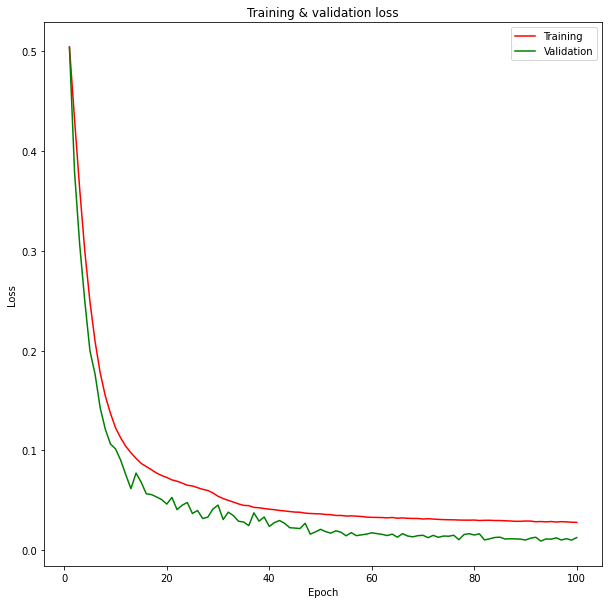

In [ ]:
fig = plot_training(training_losses, validation_losses, figsize=(10,10))

##Results & Evaluation Metrics

In [ ]:
real_masks = [imread(im) for im in target_test_filenames]
real_masks = np.array(real_masks)
real_masks.shape

(10, 120, 120)

In [ ]:
images = [imread(img_name) for img_name in input_test_filenames]

In [ ]:
pred_masks = [predict(img, model, preprocess, postprocess, device, df_bands_stats,channel_indices) for img in images]
pred_masks = np.array(pred_masks)
pred_masks.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(10, 120, 120)

https://medium.com/ml-cheat-sheet/machine-learning-evaluation-metrics-b89b8832e275

https://stackoverflow.com/questions/64210521/compute-precision-and-accuracy-using-numpy

###F1, recall and balanced accuracy

In [ ]:
accuracy = accuracy_score(real_masks.ravel(), pred_masks.ravel())
precision = precision_score(real_masks.ravel(), pred_masks.ravel())
f1 = f1_score(real_masks.ravel(), pred_masks.ravel())
recall = recall_score(real_masks.ravel(), pred_masks.ravel())
roc_auc = roc_auc_score(real_masks.ravel(), pred_masks.ravel())
balanced_accuracy = balanced_accuracy_score(real_masks.ravel(), pred_masks.ravel())

print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("F1: " + str(f1))
print("Recall: " + str(recall))
print("ROC AUC: " + str(roc_auc))
print("Balanced Accuracy: " + str(balanced_accuracy))

Accuracy: 0.9909166666666667
Precision: 0.9076863653920433
F1: 0.8778483376914458
Recall: 0.8499095840867993
ROC AUC: 0.9232287864104105
Balanced Accuracy: 0.9232287864104105


###Total Ice Surface

In [ ]:
real_ice_surface = real_masks.sum()
real_ice_surface

5530.0

In [ ]:
predicted_ice_surface = pred_masks.sum()
predicted_ice_surface

5178

In [ ]:
ice_surface_dif_porc = (predicted_ice_surface - real_ice_surface) / real_ice_surface
ice_surface_dif_porc

-0.06365280289330923

###ROC Curve

In [ ]:
# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(2):
#     fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# logit_roc_auc = roc_auc_score(real_masks.ravel(), output.ravel()))
# fpr, tpr, thresholds = roc_curve(real_masks.ravel(), clf.predict_proba(x_test)[:,1])
# plt.figure()
# plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
# plt.show()

##Save results summary to dataframe

In [ ]:
model_id = '3583866b-2e23-46fc-860b-ad194d8da0b9'
path = '/content/drive/MyDrive/Thesis_Data/Models/'

results_dict = {'model_id':model_id,
                'date':today,
                'channels': [channels],
                'mask_buffer': mask_buffer,
                'transformations': str(transforms_training),
                'criterion':str(criterion),
                'learning_rate':learning_rate,
                'epochs':epochs,
                'accuracy':accuracy,
                'precision':precision,
                'f1':f1,
                'recall':recall,
                'roc_auc':roc_auc,
                'balanced_accuracy':balanced_accuracy,
                'real_ice_surface':real_ice_surface,
                'predicted_ice_surface':predicted_ice_surface,
                'ice_surface_dif_porc':ice_surface_dif_porc
                }

#try to read the dataframe and append results
try: 
  df_results = pd.read_pickle(path+'models_results.pkl')
  #drop results from same model id
  df_results.drop(df_results[df_results.model_id == results_dict['model_id']].index, inplace=True)
  #append new results
  df_results = df_results.append(pd.DataFrame(results_dict))
  #df_results.rename(columns={"bands":"channels"}, inplace=True)

#else we create the dataframe
except:
  df_results = pd.DataFrame(results_dict)

#reset index and save the dataframe in pkl
df_results.reset_index(drop=True, inplace=True)
df_results.to_pickle(path + "models_results.pkl")

df_results 

model_id  ...                                    transformations
0  df5b4216-f6df-427a-8558-e8f726724313  ...  [FunctionWrapperDouble: {'function': functools...
1  befecf49-4ac5-4a3b-a649-aa50daa35f1d  ...  [FunctionWrapperDouble: {'function': functools...
2  838839bb-7e47-42d3-850c-09aa40f368d2  ...  [FunctionWrapperDouble: {'function': functools...
3  c4f979f1-c30c-4f2d-b437-bd4ab8ab9f4a  ...  [FunctionWrapperDouble: {'function': functools...
4  9a12743d-2682-4347-8e8c-96501e78114b  ...  [FunctionWrapperDouble: {'function': functools...
5  057f8a81-db45-4214-bc9a-cef3642433af  ...  [FunctionWrapperDouble: {'function': functools...
6  b0668ffc-0ce7-41fc-9a1b-a4297259ba79  ...  [FunctionWrapperDouble: {'function': functools...
7  2ce5db08-78e4-49b2-8314-3eb574c249e1  ...  [FunctionWrapperDouble: {'function': functools...
8  e304b54a-d253-48d2-819a-5cd3139fd2de  ...  [FunctionWrapperDouble: {'function': functools...
9  3583866b-2e23-46fc-860b-ad194d8da0b9  ...  [FunctionWrapperDouble: {'function': functools...

[10 rows x 17 columns]

##See Results (Summary Table)

In [ ]:
path = '/content/drive/MyDrive/Thesis_Data/Models/'
df_results = pd.read_pickle(path+'models_results.pkl')
df_results

model_id  ...                                    transformations
0  df5b4216-f6df-427a-8558-e8f726724313  ...  [FunctionWrapperDouble: {'function': functools...
1  befecf49-4ac5-4a3b-a649-aa50daa35f1d  ...  [FunctionWrapperDouble: {'function': functools...
2  838839bb-7e47-42d3-850c-09aa40f368d2  ...  [FunctionWrapperDouble: {'function': functools...
3  c4f979f1-c30c-4f2d-b437-bd4ab8ab9f4a  ...  [FunctionWrapperDouble: {'function': functools...
4  3583866b-2e23-46fc-860b-ad194d8da0b9  ...  [FunctionWrapperDouble: {'function': functools...
5  9a12743d-2682-4347-8e8c-96501e78114b  ...  [FunctionWrapperDouble: {'function': functools...
6  057f8a81-db45-4214-bc9a-cef3642433af  ...  [FunctionWrapperDouble: {'function': functools...
7  b0668ffc-0ce7-41fc-9a1b-a4297259ba79  ...  [FunctionWrapperDouble: {'function': functools...
8  2ce5db08-78e4-49b2-8314-3eb574c249e1  ...  [FunctionWrapperDouble: {'function': functools...
9  e304b54a-d253-48d2-819a-5cd3139fd2de  ...  [FunctionWrapperDouble: {'function': functools...

[10 rows x 17 columns]

##Save the model

In [ ]:
path = '/content/drive/MyDrive/Thesis_Data/Models/'
model_name =  model_id + '.pt'
torch.save(model.state_dict(), path + model_name)
fig.savefig(path + model_id + '.jpg')

##Remove Models

In [ ]:
# model_id = '838839bb-7e47-42d3-850c-09aa40f368d2'
# path = '/content/drive/MyDrive/Thesis_Data/Models/'
# df_results = pd.read_pickle(path+'models_results.pkl')
# df_results.drop(df_results[df_results.model_id == model_id].index, inplace=True)
# df_results.reset_index(drop=True, inplace=True)
# df_results.to_pickle(path + "models_results.pkl")
# try:
#   os.remove(path + model_id + '.pt')
# except:
#   pass
# df_results 

##NDSI Technique Results

In [ ]:
#Get Training Masks
train_masks = [imread(im) for im in target_training_filenames]
train_masks = np.array(train_masks)
train_masks.shape

(36, 120, 120)

In [ ]:
#Get NDSI

train_images = [imread(img_name) for img_name in input_training_filenames]
train_images = np.stack(train_images)
#train_images.shape
b3 = train_images[:,:,:,2]
b6 = train_images[:,:,:,5]
ndsi = (b3-b6)/(b3+b6)
ndsi.shape #argentina is nan here

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


(36, 120, 120)

Exclude Argentina

In [ ]:
train_masks = np.where(np.isnan(ndsi), np.nan, train_masks) #make null values in argentina side
train_masks = train_masks[~np.isnan(train_masks)] #remove null

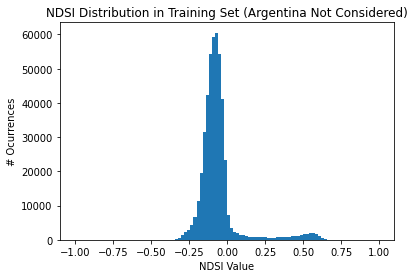

In [ ]:
#NDSI Histogram
calculate_histogram(ndsi, None, 100, -1, 1, 'NDSI Distribution in Training Set (Argentina Not Considered)', 'NDSI Value', '# Ocurrences')

In [ ]:
#ndsi_threshold = np.where(ndsi > 0,1,0) #calculate ndsi flag with threshold
#ndsi_threshold = np.where(np.isnan(ndsi),np.nan,ndsi_threshold) #make argentina null
#ndsi_threshold = ndsi_threshold[~np.isnan(ndsi_threshold)] #remove null (argentina)

In [ ]:
# #Option 2
# ndsi_images = [img[:,:,9] for img in images]
# ndsi_threshold = [np.where(img < -0.1,1,0) for img in ndsi_images]
# ndsi_threshold = np.stack(ndsi_threshold)

###Finding best threshold


In [ ]:
import math as m

In [ ]:
df_ndsi = None

for i in range(-100,101):
  threshold = i/100
  ndsi_threshold = np.where(ndsi > threshold,1,0) #calculate ndsi flag with threshold
  
  ndsi_threshold = np.where(np.isnan(ndsi),np.nan,ndsi_threshold) #make argentina null
  ndsi_threshold = ndsi_threshold[~np.isnan(ndsi_threshold)] #remove null (argentina)

  recall = recall_score(train_masks.ravel(), ndsi_threshold.ravel())
  f1 = f1_score(train_masks.ravel(), ndsi_threshold.ravel())
  balanced_accuracy = balanced_accuracy_score(train_masks.ravel(), ndsi_threshold.ravel())
  precision = precision_score(train_masks.ravel(), ndsi_threshold.ravel(),average='micro')
  tn, fp, fn, tp = confusion_matrix(train_masks.ravel(), ndsi_threshold.ravel()).ravel()
  specificity = tn / (tn+fp)

  adrien =  1-(recall*specificity)

  data = {"threshold":[threshold],"recall":[recall],"f1":[f1],
          "balanced accuracy":[balanced_accuracy],"precision":[precision],
          "adrien":[adrien]}
  try:
    #append new results
    df_ndsi = df_ndsi.append(pd.DataFrame(data))
  
  #else we create the dataframe
  except:
    df_ndsi = pd.DataFrame(data)

df_ndsi.reset_index(drop=True, inplace=True)

In [ ]:
#df_ndsi.to_pickle("/content/drive/MyDrive/Thesis_Data/Models/df_ndsi_nobuffer.pkl")
df_ndsi = pd.read_pickle("/content/drive/MyDrive/Thesis_Data/Models/df_ndsi_nobuffer.pkl")

<function matplotlib.pyplot.plot>

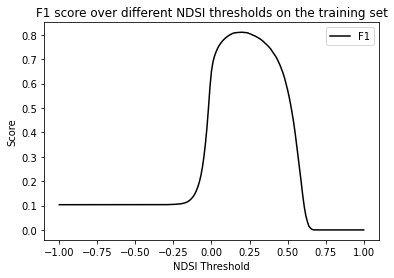

In [ ]:
#plt.plot(df_ndsi['threshold'], df_ndsi['recall'], color='blue', label='Recall')
#plt.plot(df_ndsi['threshold'], df_ndsi['precision'], color='red', label='Precision')
#plt.plot(df_ndsi['threshold'], df_ndsi['balanced accuracy'], color='yellow', label='Balanced Accuracy')
plt.plot(df_ndsi['threshold'], df_ndsi['f1'], color='black', label='F1')
#plt.plot(df_ndsi['threshold'], df_ndsi['adrien'], color='green', label='Adrien')

plt.xlabel('NDSI Threshold')
plt.ylabel('Score')
plt.title('F1 score over different NDSI thresholds on the training set')
plt.legend()
plt.plot

In [ ]:
best_threshold = df_ndsi[df_ndsi.index == df_ndsi['f1'].argmax()]['threshold'].values[0]
best_threshold

0.2

###Aplying NDSI Technique over Test Set

In [ ]:
best_threshold = 0.2

In [ ]:
#Get Training Masks
test_masks = [imread(im) for im in target_test_filenames]
test_masks = np.array(test_masks)
test_masks.shape

(10, 120, 120)

In [ ]:
#Get NDSI
test_images = [imread(img_name) for img_name in input_test_filenames]
test_images = np.stack(test_images)
#test_images.shape
b3 = test_images[:,:,:,2]
b6 = test_images[:,:,:,5]
ndsi = (b3-b6)/(b3+b6)
ndsi.shape #argentina is nan here

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


(10, 120, 120)

In [ ]:
test_masks = np.where(np.isnan(ndsi), np.nan, test_masks) #make null values in argentina side
test_masks = test_masks[~np.isnan(test_masks)] #remove null

In [ ]:
ndsi_threshold = np.where(ndsi > best_threshold,1,0)
ndsi_threshold.shape

(10, 120, 120)

In [ ]:
ndsi_threshold = np.where(np.isnan(ndsi),np.nan,ndsi_threshold) #make argentina null
ndsi_threshold = ndsi_threshold[~np.isnan(ndsi_threshold)] #remove null (argentina)

In [ ]:
accuracy = accuracy_score(test_masks.ravel(), ndsi_threshold.ravel())
precision = precision_score(test_masks.ravel(), ndsi_threshold.ravel(),average='micro')
f1 = f1_score(test_masks.ravel(), ndsi_threshold.ravel())
recall = recall_score(test_masks.ravel(), ndsi_threshold.ravel())
roc_auc = roc_auc_score(test_masks.ravel(), ndsi_threshold.ravel())
balanced_accuracy = balanced_accuracy_score(test_masks.ravel(), ndsi_threshold.ravel())

print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("F1: " + str(f1))
print("Recall: " + str(recall))
print("ROC AUC: " + str(roc_auc))
print("Balanced Accuracy: " + str(balanced_accuracy))

Accuracy: 0.9879043870596141
Precision: 0.9879043870596141
F1: 0.876338329764454
Recall: 0.8880650994575046
ROC AUC: 0.9405160400136493
Balanced Accuracy: 0.9405160400136492


In [ ]:
real_ice_surface = test_masks.sum()
real_ice_surface

5530.0

In [ ]:
predicted_ice_surface = ndsi_threshold.sum()
predicted_ice_surface

5678.0

In [ ]:
ice_surface_dif_porc = (predicted_ice_surface - real_ice_surface) / real_ice_surface
ice_surface_dif_porc

0.026763110307414104

##Load the model

In [ ]:
path = '/content/drive/MyDrive/Thesis_Data/Models/'
model_id = 'befecf49-4ac5-4a3b-a649-aa50daa35f1d.pt'

# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model = UNet(in_channels=len(channels),
             out_channels=2,
             n_blocks=4,
             start_filters=4,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)

model_name = model_id + '.pt'
model_weights = torch.load(path + model_id, map_location=device)

model.load_state_dict(model_weights)

<All keys matched successfully>

##Plot a sample prediction

https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.08-Multiple-Subplots.ipynb

python colab best way to plot 3 images

https://stackoverflow.com/questions/19471814/display-multiple-images-in-one-ipython-notebook-cell/27795087

https://matplotlib.org/stable/tutorials/introductory/images.html


https://matplotlib.org/stable/gallery/images_contours_and_fields/image_transparency_blend.html

https://stackoverflow.com/questions/56495790/how-to-plot-only-some-cells-with-certain-values-of-an-array-and-others-not-with

In [ ]:
real_masks = [imread(im) for im in target_test_filenames]
real_masks = np.array(real_masks)
real_masks.shape

(10, 120, 120)

In [ ]:
images = [imread(img_name) for img_name in input_test_filenames]

In [ ]:
pred_masks = [predict(img, model, preprocess, postprocess, device, df_bands_stats,channel_indices) for img in images]
pred_masks = np.array(pred_masks)
pred_masks.shape

(10, 120, 120)

In [ ]:
path = '/content/drive/MyDrive/Thesis_Data/Models/'
path = path + model_id.rsplit(".")[0]
path

'/content/drive/MyDrive/Thesis_Data/Models/befecf49-4ac5-4a3b-a649-aa50daa35f1d'

In [ ]:
try:
  os.mkdir(path)
except:
  pass

Buffer_0_Number_11_Mask.tif


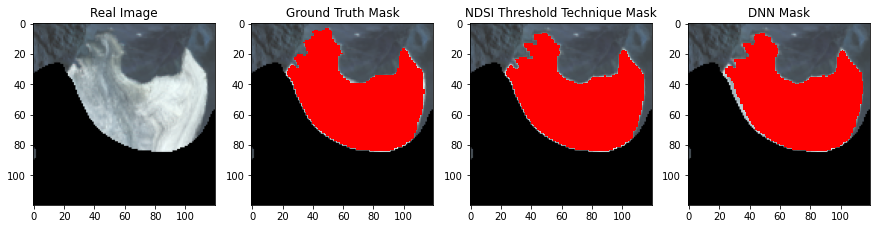

Buffer_0_Number_56_Mask.tif


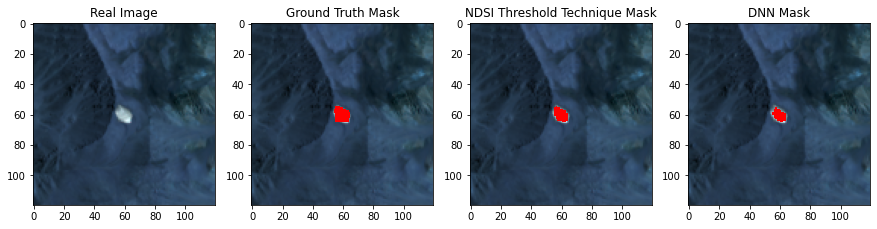

Buffer_0_Number_58_Mask.tif


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


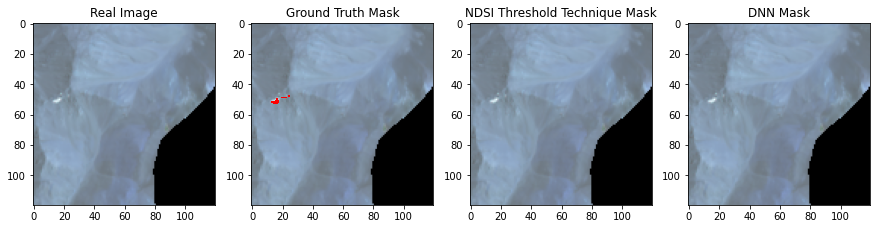

Buffer_0_Number_135_Mask.tif


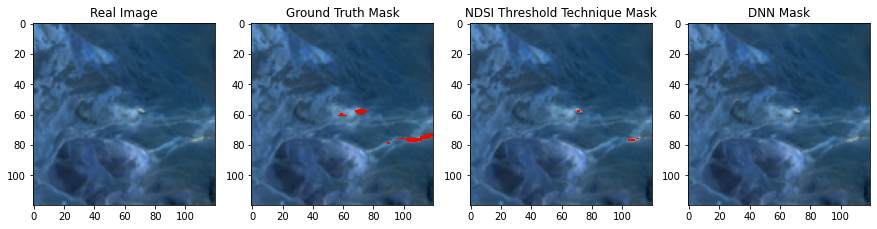

Buffer_0_Number_188_Mask.tif


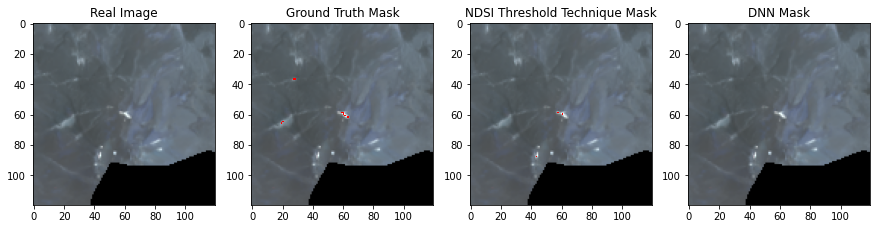

Buffer_0_Number_195_Mask.tif


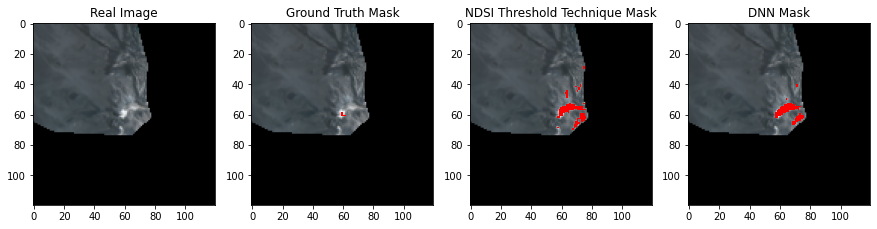

Buffer_0_Number_307_Mask.tif


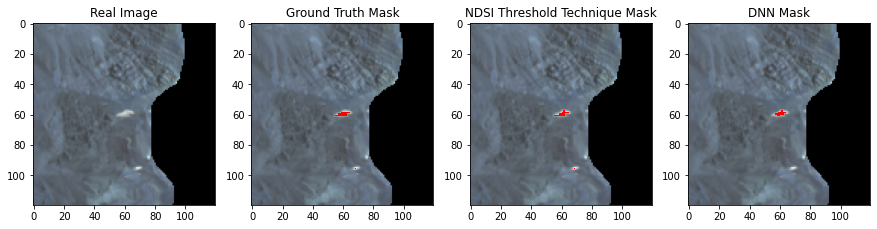

Buffer_0_Number_328_Mask.tif


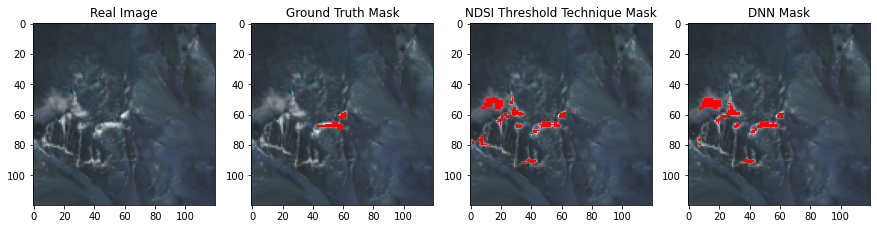

Buffer_0_Number_352_Mask.tif


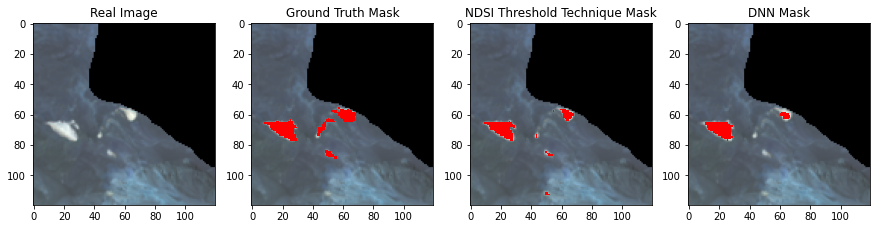

Buffer_0_Number_354_Mask.tif


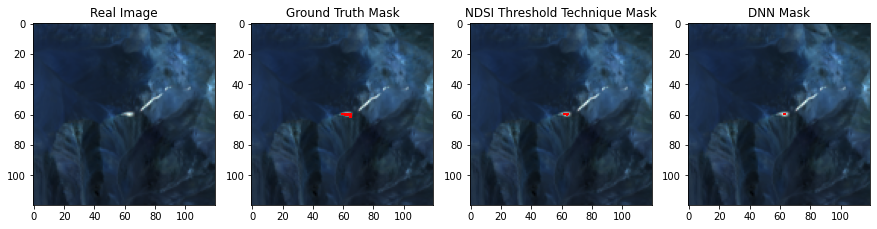

In [ ]:
for i in range(0,10):
  print(target_test_filenames[i].rsplit('/')[-1])

  #plot figure
  plt.figure(figsize=[15,15])

  #get real image
  im_real = images[i][:,:,1:4]
  im_real = re_normalize(im_real) #from 0-255

  plt.subplot(1,4,1)
  plt.imshow(im_real)
  plt.title('Real Image')

  #get real mask (ground truth)
  im_real_mask = real_masks[i,:,:]
  im_real_mask =np.ma.masked_where(im_real_mask==0, im_real_mask)

  plt.subplot(1, 4, 2)
  plt.imshow(im_real)
  plt.imshow(im_real_mask, cmap = colors.ListedColormap(['red']))
  #plt.contour(im_real_mask,  colors='red')
  #plt.imshow(im_pred_mask, cmap = colors.ListedColormap(['orange']))
  plt.title('Ground Truth Mask')

  #get ndsi mask
  im_ndsi_mask = ndsi_threshold[i,:,:]
  im_ndsi_mask = np.ma.masked_where(im_ndsi_mask==0, im_ndsi_mask)

  plt.subplot(1, 4, 3)
  plt.imshow(im_real)
  plt.imshow(im_ndsi_mask, cmap = colors.ListedColormap(['red']))
  plt.title('NDSI Threshold Technique Mask')

  #get predicted mask
  im_pred_mask = pred_masks[i,:,:]
  im_pred_mask = np.ma.masked_where(im_pred_mask==0, im_pred_mask)

  plt.subplot(1, 4, 4)
  plt.imshow(im_real)
  plt.imshow(im_pred_mask, cmap = colors.ListedColormap(['red']))
  plt.title('DNN Mask')

  plt.savefig(path+'/'+str(i)+'.png')

  plt.show()
  

##Input Analysis

In [ ]:
#Get test images
test_images = [imread(img_name) for img_name in input_test_filenames]
test_images = np.stack(test_images)
test_images.shape

(10, 120, 120, 10)

In [ ]:
#Get real masks
real_masks = [imread(im) for im in target_test_filenames]
real_masks = np.array(real_masks)
real_masks.shape

(10, 120, 120)

In [ ]:
#Select 1 test image, its mask and show
i = 8
test_image = test_images[i,:,:,:]
im_real_rgb = test_image[:,:,1:4] #get rgb channels
im_real_rgb = re_normalize(im_real_rgb) #from 0-255

real_mask = real_masks[i,:,:]

0.7189349112426034
0.5664335664335665
0.9838056680161943


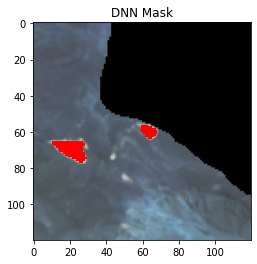

In [ ]:
#Predict mask and get f1
pred_mask = [predict(test_image, model, preprocess, postprocess, device, df_bands_stats, channel_indices)]
pred_mask = np.array(pred_mask)
pred_mask = pred_mask[0,:,:]
initial_f1 = f1_score(real_mask.ravel(), pred_mask.ravel())
initial_recall = recall_score(real_mask.ravel(), pred_mask.ravel())
initial_prec = precision_score(real_mask.ravel(), pred_mask.ravel())
print(initial_f1)
print(initial_recall)
print(initial_prec)

#plot predicted mask
im_pred_mask = pred_mask
im_pred_mask = np.ma.masked_where(im_pred_mask==0, im_pred_mask)

plt.imshow(im_real_rgb)
plt.imshow(im_pred_mask, cmap = colors.ListedColormap(['red']))
plt.title('DNN Mask')

plt.show()


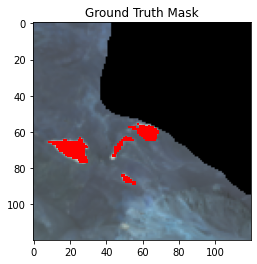

In [ ]:
#get real mask (ground truth)
im_real_mask = real_mask
im_real_mask = np.ma.masked_where(im_real_mask==0, im_real_mask)

plt.imshow(im_real_rgb)
plt.imshow(im_real_mask, cmap = colors.ListedColormap(['red']))
plt.title('Ground Truth Mask')

plt.show()


Channel hidden: 0
F1: 0.245398773006135
recall: 0.13986013986013987
precision: 1.0
Predicted mask: 


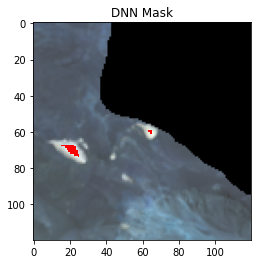

Channel hidden: 1
F1: 0.5457627118644067
recall: 0.3752913752913753
precision: 1.0
Predicted mask: 


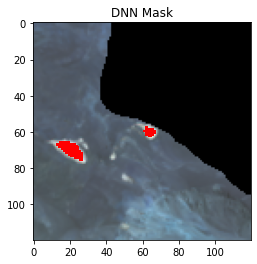

Channel hidden: 2
F1: 0.5555555555555556
recall: 0.38461538461538464
precision: 1.0
Predicted mask: 


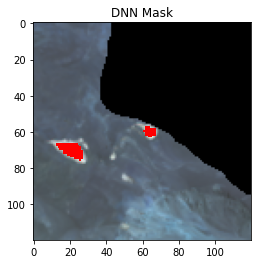

Channel hidden: 3
F1: 0.7007518796992481
recall: 0.5431235431235432
precision: 0.9872881355932204
Predicted mask: 


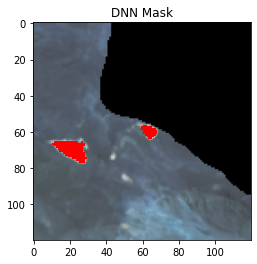

Channel hidden: 4
F1: 0.7128129602356407
recall: 0.5641025641025641
precision: 0.968
Predicted mask: 


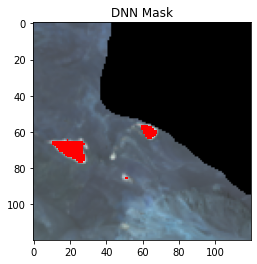

Channel hidden: 5
F1: 0.4539400665926748
recall: 0.9533799533799534
precision: 0.29788783685360526
Predicted mask: 


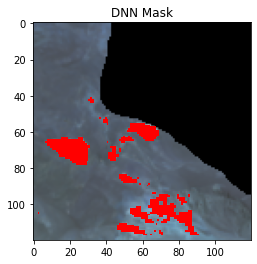

Channel hidden: 6
F1: 0.8060344827586206
recall: 0.8717948717948718
precision: 0.749498997995992
Predicted mask: 


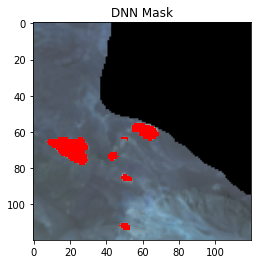

Channel hidden: 7
F1: 0.33800560672807367
recall: 0.9836829836829837
precision: 0.20406189555125726
Predicted mask: 


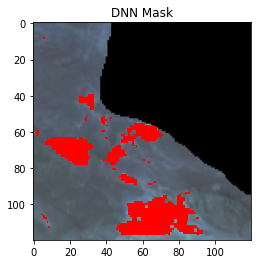

Channel hidden: 8
F1: 0.574750830564784
recall: 0.40326340326340326
precision: 1.0
Predicted mask: 


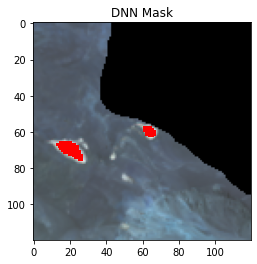

In [ ]:
df_f1 = None

for channel in range(0,9):
  
  test_image_dropout = test_image.copy()
  test_image_dropout[:,:,channel] = 0

  pred_mask = [predict(test_image_dropout, model, preprocess, postprocess, device, df_bands_stats, channel_indices)]
  pred_mask = np.array(pred_mask)
  pred_mask = pred_mask[0,:,:]
  
  f1 = f1_score(real_mask.ravel(), pred_mask.ravel())
  recall = recall_score(real_mask.ravel(), pred_mask.ravel())
  prec = precision_score(real_mask.ravel(), pred_mask.ravel())

  data = {"f1":[f1], "recall":[recall],"precision":[prec]}

  try:
      #append new results
      df_f1 = df_f1.append(pd.DataFrame(data))
  #else we create the dataframe
  except:
    df_f1 = pd.DataFrame(data)

  print("Channel hidden: " + str(channel))
  print("F1: " + str(f1))
  print("recall: " + str(recall))
  print("precision: " + str(prec))
  print("Predicted mask: ")
  
  #plot predicted mask
  im_pred_mask = pred_mask
  im_pred_mask = np.ma.masked_where(im_pred_mask==0, im_pred_mask)

  plt.imshow(im_real_rgb)
  plt.imshow(im_pred_mask, cmap = colors.ListedColormap(['red']))
  plt.title('DNN Mask')

  plt.show()


In [ ]:
df_recall['Recall'].argmin()